In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import font_manager
import re
from pathlib import Path
from tqdm import tqdm
import json
import pickle
import numpy as np
import collections

# Step 1: Look at available Chinese dialog corpora

**CallFriend**
- available `/corpora/LDC/LDC96S55`
- `/corpora/LDC/LDC96S55/doc/spkrinfo.doc`

In [ ]:
%ls /corpora/LDC/LDC96S55/cf_man_m/evltest/

In [ ]:
%ls /corpora/LDC/LDC96S55/doc

In [ ]:
!head -n 20 /corpora/LDC/LDC96S55/doc/spkrinfo.doc

In [ ]:
%less /corpora/LDC/LDC96S55/doc/spkrinfo.tbl

In [ ]:
%cat /corpora/LDC/LDC96S55/doc/cf_man_m.doc

 **Notes** <br/>
 - Actually just audio files and descriptions
 - But it still has decent demographic information of speakers
 - it looks like [this](https://catalog.ldc.upenn.edu/LDC2018S18) is the version that includes transcripts: LDC2018S18
 

In [ ]:
%ls /corpora/LDC/ | grep 'LDC2018' 

It looks like LDC2018S18 corpus is not in UW's directory

Brandon added it under /corpora/LDC/LDC2018S18

In [ ]:
%ls /corpora/LDC/LDC2018S18/data/transcripts/mandarin

In [ ]:
!head -n 10 /corpora/LDC/LDC2018S18/data/transcripts/mandarin/ma_4160.txt

See if you can get any more info on A and B speakers in ma_4160

In [ ]:
%ls /corpora/LDC/LDC2018S18/docs

In [ ]:
!cat /corpora/LDC/LDC2018S18/docs/spkrinfo.tbl

In [ ]:
#some interesting variables available in /corpora/LDC/LDC2018S18/docs/callinfo.tbl
!head -n 10 /corpora/LDC/LDC2018S18/docs/callinfo.tbl

Given that there is also some detail of the *caller* only in spkrinfo.tbl, I wonder if it would be possible to identify at least the caller in the spkrinfo.tbl file?

In [ ]:
!head -n 5 /corpora/LDC/LDC2018S18/docs/spkrinfo.tbl

In [ ]:
with open('/corpora/LDC/LDC2018S18/docs/callinfo.tbl','r') as infile:
    callfriend_raw = infile.read()

In [ ]:
#get counts of ages
all_ages = re.findall('(?<=age=).*?(?=\s)',callfriend_raw)
Counter(all_ages)

In [ ]:
#get counts of all sexes
all_sexes = re.findall('(?<=sex=)[M|F]',callfriend_raw)
Counter(all_sexes)

In [ ]:
#Find stuff in directories

p = Path('/corpora/LDC/LDC2018S18/data/transcripts/mandarin/')
files = [f for f in p.iterdir() if f.is_file()]


In [ ]:
ni_count = 0
nin_count = 0

for i in tqdm(range(0,len(files))):
    with open(str(files[i].absolute()),'r') as infile:
        raw = infile.read()
        
        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))
        
        if bool(re.findall('您',raw)):
            print(str(files[i].absolute()))

In [ ]:
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

In [ ]:
%less /corpora/LDC/LDC2018S18/data/transcripts/mandarin/ma_5930.txt

### Explore relations between CallFriend speakers

Question: how can I link the call ids to the speaker ids?

In [ ]:
!head -n 5 /corpora/LDC/LDC96S55/doc/callinfo.tbl

In [ ]:
!head -n 20  /corpora/LDC/LDC96S55/doc/spkrinfo.tbl

 For example: <br/> 
 ma_4160,M,30,22,Anhui,203778bah means: <br/>
- Call-ID = ma_4160
- Gender of caller = Male
- Age of caller = 30
- Years of education completed by caller = 22
- Where the caller grew up (typically a state name) = Anhui
- Area-code plus first three digits of telephone number dialed (last four digits of number are encrypted as three letters) = 203778bah <br/> <br/>
Note that there seem to be plenty of missing values

In [ ]:
%ls /corpora/LDC/LDC96S55/cf_man_m/devtest/

In [ ]:
!head -n 10 /corpora/LDC/LDC96S55/cf_man_m/devtest/ma_4559.sph

In [ ]:
%less /corpora/LDC/LDC96S55/doc/cf_man_m.doc

In [ ]:
with open('/corpora/LDC/LDC96S55/doc/callinfo.tbl','r') as infile:
    raw= infile.read().split('\n')

In [ ]:
import re
call_ids = [re.findall('ma_[0-9]*',item)[0] for item in raw if len(item)>0]
call_ids = sorted(call_ids)
len(call_ids)

In [ ]:
call_ids[0:5]

In [ ]:
with open('/corpora/LDC/LDC96S55/doc/spkrinfo.tbl','r') as infile:
    raw= infile.read().split('\n')
speaker_ids = [re.findall('ma_[0-9]*',item)[0] for item in raw if len(item)>0]
speaker_ids = sorted(speaker_ids)
len(speaker_ids)

In [ ]:
len(set(speaker_ids).intersection(set(call_ids)))

Actually the speaker ids and call ids are overlapping... how does that work? maybe the first id of the call table is actually speaker ids and the PINs are the call ids? That would imply duplicate PIN ids with 2 different ma_ numbers

In [ ]:
with open('/corpora/LDC/LDC96S55/doc/callinfo.tbl','r') as infile:
    raw= infile.read().split('\n')


In [ ]:
test = raw[0]
test

In [ ]:
PINs = [re.findall('(?<=PIN=)[0-9]*(?=|)',item)[0] for item in raw if len(item)>0]
len(PINs)

In [ ]:
len(set(PINs))

There are no duplicated PIN numbers either. My guess is that only demographics of the caller are recorded, and not the recipient. 

Trying **2005 NIST Speaker Recognition Evaluation Training Data** <br/>
- `/corpora/LDC/LDC11S01`

In [ ]:
%ls /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1

In [ ]:
!head -n 5 /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1/index.html

In [ ]:
%ls /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1/data/

In [ ]:
!head -n 5 /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1/data/asr_tran/jaab.ctm

In [ ]:
%less /corpora/LDC/LDC11S01/nist_2005_sre_tr_d1/doc/file.tbl

Trying **MAGICDATA Mandarin Chinese Conversational Speech Corpus: MDT2021S003** <br/>
- https://www.openslr.org/123/

In [ ]:
%ls MDT2021S003/

In [ ]:
!head -n 5 MDT2021S003/SPKINFO.txt

In [ ]:
import pandas as pd
with open('MDT2021S003/SPKINFO.txt','r') as infile:
    df = pd.read_table(infile)
df.head(5)

In [ ]:
from collections import Counter
Counter(df.AGE)

In [ ]:
Counter(df.GENDER)

Problem with this data: very little demographic information available for speakers.

Trying **HKUST/MTS: A Very Large Scale Mandarin
Telephone Speech Corpus** <br/>
- https://www.researchgate.net/profile/David-Graff-5/publication/220758477_HKUSTMTS_A_very_large_scale_Mandarin_telephone_speech_corpus/links/004635346a94cf2642000000/HKUST-MTS-A-very-large-scale-Mandarin-telephone-speech-corpus.pdf
- LDC2005T32
- Not downloaded on Patas, but says it's installed [here](https://cldb.ling.washington.edu/live/livesearch-corpus-form.php)

In [ ]:
%ls /corpora/LDC/ | grep 'LDC200' 

According to Brandon, this is under `/corpora/LDC/LDC05T32`

In [ ]:
%ls /corpora/LDC/LDC05T32/docs

In [ ]:
!head -n 5 /corpora/LDC/LDC05T32/docs/calldata-train.txt

In [ ]:
%less /corpora/LDC/LDC05T32/docs/file.tbl

Interesting **notes** from readme: <br/>
- Most subjects did not previously know each other.
- Topics were proposed to subjects
- Subjects were asked to provide several pieces of demographic
information, including gender, age, native language/dialect,
birthplace, education, occupation, phone type, etc.

In [ ]:
%ls /corpora/LDC/LDC05T32/data/trans/train

Do some exploratory statistics on the demographics of training data

In [ ]:

with open('/corpora/LDC/LDC05T32/docs/calldata-train.txt','r') as infile:
    demographics = pd.read_table(infile)

In [ ]:
demographics.head(5)

In [ ]:
#rename all columns to have underscores instead of spaces
original_cols = list(demographics.columns)
new_cols = [re.sub(' ','_',item) if ' ' in item else item for item in list(demographics.columns)]

change_cols = dict()
for i in range(0,len(original_cols)):
    change_cols[original_cols[i]] = new_cols[i]
demographics = demographics.rename(columns=change_cols)
demographics.columns

In [ ]:
#Get a histogram of ages of callers in buckets of decades
all_ages = list(demographics.Age_A)+list(demographics.Age_B)
sorted(Counter(all_ages).items())


In [ ]:
print(max(Counter(all_ages).keys()))
print(min(Counter(all_ages).keys()))

In [ ]:
def get_decade(a)->str:
    output = ''
    if a< 10:
        output += '0s'
    elif a <20:
        output += '10s'
    elif a <30:
        output += '20s'
    elif a <40:
        output += '30s'
    elif a <50:
        output += '40s'
    elif a <60:
        output += '50s'
    elif a <70:
        output += '60s'  
    return output

In [ ]:
demographics['decade_A'] = demographics.Age_A.apply(get_decade)
demographics['decade_B'] = demographics.Age_B.apply(get_decade)

In [ ]:
demographics.head(5)

In [ ]:
#graph a sorted histogram of decades
all_decades = list(demographics.decade_A)+list(demographics.decade_B)

plt.bar(Counter(all_decades).keys(),Counter(all_decades).values())
plt.suptitle("Distribution of ages of caller participants")

In [ ]:
#graph sorted pairs of participants to conversations

age_of_call = []
for i in range(0,len(demographics)):
    
    a = demographics.decade_A.iloc[i]
    b = demographics.decade_B.iloc[i]
    
    pair = sorted([a,b])
    age_of_call.append(pair[0]+' and '+pair[1])


In [ ]:
age_pairs = Counter(age_of_call).most_common()

In [ ]:
plt.bar([item[0] for item in age_pairs],[item[1] for item in age_pairs])
plt.suptitle("Distribution of ages pairs")
plt.xticks(rotation=90)

**notes**
- most calls are among people in their 20s
- most calls are between people both of whom are in their 20s

In [ ]:
#Get distributions of topics discussed
with open('/corpora/LDC/LDC05T32/docs/topic-list.txt','r') as infile:
    topics_raw = infile.read()

In [ ]:
%less /corpora/LDC/LDC05T32/docs/topic-list.txt

In [ ]:
raw_list = re.findall('[0-9]{1,2}\..*(?=\n)',topics_raw)
topic_dict = Counter()
for row in raw_list:
    topic_key = int(re.findall('[0-9]*(?=\.)',row)[0])
    topic = re.findall('(?<=[0-9]\. ).*',row)[0]
    topic_dict[topic_key]=topic
    
topic_dict

In [ ]:
def index_to_topic(a:int) -> str:
    
    return(topic_dict[a])


In [ ]:
demographics['Topic_Name'] = demographics.Topic_ID.apply(index_to_topic)

In [ ]:
Counter(demographics.Topic_Name).most_common()

In [ ]:
#get a simple distribution of 你 and 您 across training data

In [ ]:
%ls /corpora/LDC/LDC05T32/data/trans/train/

In [ ]:
!head -n 5 /corpora/LDC/LDC05T32/data/trans/train/20040527_210939_A901153_B901154.txt

In [ ]:
!file /corpora/LDC/LDC05T32/data/trans/train/20040527_210939_A901153_B901154.txt

Important lesson learned from [this thread](https://stackoverflow.com/questions/23731176/how-to-print-chinese-characters-stored-in-a-file-with-charset-iso-8859-1-in-py): "file is probably wrong, since it only 'guesses' the encoding. Using gb18030 as the encoding gives the correct result"

In [ ]:
with open('/corpora/LDC/LDC05T32/data/trans/train/20040527_210939_A901153_B901154.txt','r',encoding='iso-8859-1') as infile:
    raw = infile.read()

In [ ]:
with open('/corpora/LDC/LDC05T32/data/trans/train/20040527_210939_A901153_B901154.txt','r',encoding='gb18030') as infile:
    raw = infile.read()

In [ ]:
#Find stuff in directories

p = Path('/corpora/LDC/LDC05T32/data/trans/train/')
files = [f for f in p.iterdir() if f.is_file()]


In [ ]:
ni_count = 0
nin_count = 0

for i in tqdm(range(0,len(files))):
    with open(str(files[i].absolute()),'r',encoding='gb18030') as infile:
        raw = infile.read()
        
        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))
        

In [ ]:
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

Trying **CallHome**
- /corpora/LDC/LDC96S34 

In [ ]:
%ls /corpora/LDC/LDC96S34

In [ ]:
!less /corpora/LDC/LDC96S34/0readme.1st

In [ ]:
%ls /corpora/LDC/LDC96T16

Trying **CRECIL**
- [paper](http://www.lrec-conf.org/proceedings/lrec2022/pdf/2022.lrec-1.250.pdf)
- [Github](https://github.com/bistu-nlp-lab/CRECIL)

In [20]:
%ls ../CRECIL/Orginal_data/relation/

only_relation.pkl  only_relation.txt  relation.pkl  relation.txt


In [129]:
%ls ../CRECIL/Orginal_data/relation/

only_relation.pkl  only_relation.txt  relation.pkl  relation.txt


In [130]:
%less ../CRECIL/Orginal_data/relation/relation.txt

In [7]:
%less ../CRECIL/Final_Data/train.json

In [3]:
with open('../CRECIL/Final_Data/train.json','r') as infile:
    train_df = json.loads(infile.read())

In [4]:
#repetitive box
dialog_chars = Counter()
len_dict = Counter()

for i in range(0,len(train_df)):
    char_set = set()
    for j in range(0,len(train_df[i][0])):
        char_set.add(re.findall('.*(?<=:)',train_df[i][0][j])[0])
    dialog_chars[i] = len(char_set)
    
    if len(char_set) not in len_dict:
        len_dict[len(char_set)] = 0
    len_dict[len(char_set)] += 1
    
pair_dialog_indices = [i for i in list(dialog_chars.keys()) if dialog_chars[i]==2]
all_roles = dict()
for dg in pair_dialog_indices:
    for i in range(0,len(train_df[dg][1])):
        if train_df[dg][1][i]['r'][0] not in all_roles:
            all_roles[train_df[dg][1][i]['r'][0]] = 0
        all_roles[train_df[dg][1][i]['r'][0]] += 1    
        
pair_df = []
pair_dialog_df = [train_df[i] for i in pair_dialog_indices]

for item in pair_dialog_df:
    

    S1_title = ''
    S2_title = ''

    for rel in item[1]:

        if rel['x']=='S 1' and rel['y']=='S 2':

            S1_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S1_title)>0: 
                S1_title=S1_title[0]

        if rel['y']=='S 1' and rel['x']=='S 2':

            S2_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S2_title)>0: 
                S2_title=S2_title[0]

        if len(S1_title)>0 and len(S2_title)>0:

            S1_relation = S1_title+":"+S2_title
            S2_relation = S2_title+":"+S1_title

            for line in item[0]:
                party = re.findall('^S\s[1-2]',line)
                if len(party)>0: 
                    party=party[0]

                    if party =='S 1':
                        pair_df.append((line,S1_relation))
                    elif party=='S 2':
                        pair_df.append((line,S2_relation))

pair_df = pd.DataFrame(list(pair_df),columns=['text','relation'])

rel_dict = dict()
for rel in list(pair_df.relation.unique()):
    rel_dict[rel]=dict()
    rel_dict[rel]['你']=0
    rel_dict[rel]['您']=0
    
for i in range(0,len(pair_df)):
        
    rel_dict[pair_df.relation.iloc[i]]['你'] += len(re.findall('你',pair_df.text.iloc[i]))
    rel_dict[pair_df.relation.iloc[i]]['您'] += len(re.findall('您',pair_df.text.iloc[i]))
    
#reverse the order of the nested keys in rel_dict
rel_dict_2 = dict()
rel_dict_2['你'] = dict()
rel_dict_2['您'] = dict()

for item in rel_dict:
    rel_dict_2['你'][item] = rel_dict[item]['你']
    rel_dict_2['您'][item] = rel_dict[item]['您']
    
#Present data as an observation table
rel_df = pd.DataFrame(rel_dict_2)

Something just dawning on me now: in the transcript with multiple people, it's not super clear who each line is being directed _at_. This is a problem, because that's the signal that I'm hoping will tell me how formality is being used. However it seems like this is equality important for relation extraction, so I can learn how the baseline/other approaches resolve this. 

In [3]:
ni_count = 0
nin_count = 0

for i in tqdm(range(0,len(train_df))):

    raw_list = train_df[i][0]
    for raw in raw_list:

        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))


100%|██████████████████████████████████████| 482/482 [00:00<00:00, 27232.07it/s]


In [4]:
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

28.39% of "you"s are 您
2800 instances out of 9863


In [5]:
with open('../CRECIL/Final_Data/test.json','r') as infile:
    test_df = json.loads(infile.read())

In [6]:
with open('../CRECIL/My_home_data/final_0.json','r') as infile:
    final_0 = json.loads(infile.read())

In [5]:
with open('../CRECIL/My_home_data/final.json','r') as infile:
    final_df = json.loads(infile.read())
    

In [9]:
final_0[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1', 'y': 'S 3', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': 'S 4', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': 'S 5', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1', 'y': 'S 6', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': 'S 1', 'y': '小张', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1', 'y': '二哥', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': '孩子', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': 'S 1', 'y': '老同志', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': 'S 1', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:siblings'], 'rid': [22]},
 {'x': 'S 2', 'y': 'S 4', 'r': ['per:siblings'], 'rid': [22]},
 {'x': 'S 2', 'y': 'S 5', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 6', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': '小张', 'r': ['unanswerable'], 'rid

In [10]:
len(all_relations)

NameError: name 'all_relations' is not defined

In [8]:
final_df[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1', 'y': 'S 3', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': 'S 4', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': 'S 5', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1', 'y': 'S 6', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': 'S 1', 'y': '小张', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1', 'y': '二哥', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': '孩子', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': 'S 1', 'y': '老同志', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': 'S 1', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:siblings'], 'rid': [22]},
 {'x': 'S 2', 'y': 'S 4', 'r': ['per:siblings'], 'rid': [22]},
 {'x': 'S 2', 'y': 'S 5', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 6', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': '小张', 'r': ['unanswerable'], 'rid

In [7]:
final_df[0][0]

['S 1: 爸，动画片儿哪频道啊？',
 'S 2: 看哪门子动画片呀----看连续剧',
 'S 3: 小张你这菜可咸点儿啊！',
 'S 4: 二哥，你霸着鸡腿儿你一人吃你能不咸嘛你，人家一礼拜可才见一回晕腥！唉唉唉，动物世界动物世界……',
 'S 5: 哎哎哎，咱爸今儿是怎么回事儿？从单位一回来就打蔫儿，饭都不吃就楼底下溜达去了这大冷的天儿……',
 'S 3: 可能是添什么心事了，唉，是不是今儿跟单位巧遇哪位中午丧偶的女同志……',
 'S 5: 说话不着调……',
 'S 3: 咱妈去世两年多了，咱爸论条件，论身体，要为这烦恼，那还不要多正常有多正常？',
 'S 4: 咱爸这岁数……不至于……',
 'S 1: 爱情不分老少，人生没有单行道。',
 'S 5: 嘿嘿嘿，这孩子哪儿学来这么些乱七八糟的……',
 'S 2: 还不都是你们招的！咱爸上了一天班，累了，躺会儿，你们就非说他老人家惦记给咱们找后妈，这是那儿跟那儿啊！',
 'S 1: 姑姑，你说大人为什么都这么愿意上班啊？',
 'S 4: 啊也不是所有的大人都愿意上班--比如你二叔，在家闲了三年他都不着急……',
 'S 3: 谁闲着了？我挂着两个单位，兼着三个公司的副总经理，我比谁不忙呀！',
 'S 4: 啊呸！你忙！咱爸他们单位，已经好几次想把爸的办公桌从局长室请出去啦！',
 'S 5: 可你爸也是，反正也退了，挨家享两天轻福不好么！何必每星期还大老远的跑到局里去“顾问”两次--害得人家车接车送的，给国家省点儿气油好不好？',
 'S 2: 老同志嘛，工作需要嘛！',
 'S 5: 你算了吧！你爸呀，纯属老糊涂了！',
 'S 3: 还不光是老……那是他们别人，咱爸可是越老越明白！',
 'S 4: 根本不可能……那是绝对没错儿！我就同意二哥这观点！',
 'S 2: 我就反对你们这样……谁反对你们我就反对谁！',
 'S 5: 唉唉你们今天怎么了？平常你们不总说咱爸……',
 'S 2: 没有！根本没有！和平，你在背后不也总说咱爸是个明白人吗？',
 'S 5: 我那是哄着他玩儿哪！',
 'S 1: 妈！爷爷……',
 'S 5: 爷爷怎么啦？爷爷有缺点就不许人说呀？……可不嘛，有缺点你说，没缺点你什么呀？不是我批评你们，背后议论人这毛病你们也该改改啦！要不咱爸是明白人，不往心里

How does the BERT model from the paper work?

In [18]:
%ls ../CRECIL/bert/

bert_today/  extract_features.py  optimization.py    tokenization.py
evaluate.py  modeling.py          run_classifier.py


In [20]:
%less ../CRECIL/bert/modeling.py

Find number of speakers per dialogue, and visualize

In [25]:
len(train_df)

482

In [4]:
dialog_chars = Counter()
len_dict = Counter()

for i in range(0,len(train_df)):
    char_set = set()
    for j in range(0,len(train_df[i][0])):
        char_set.add(re.findall('.*(?<=:)',train_df[i][0][j])[0])
    dialog_chars[i] = len(char_set)
    
    if len(char_set) not in len_dict:
        len_dict[len(char_set)] = 0
    len_dict[len(char_set)] += 1

Text(0.5, 0.98, 'No. of dialogs by no. of speakers in dialog')

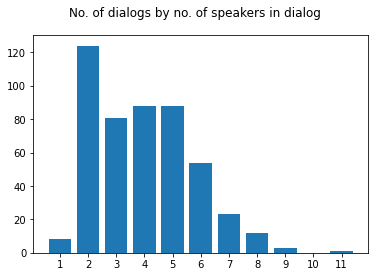

In [8]:
#No. of dialogs by no. of speakers in dialog
plot = plt.bar(len_dict.keys(),len_dict.values())
plt.xticks(range(1, len(len_dict.values())+2))
plt.suptitle("No. of dialogs by no. of speakers in dialog")

In [48]:
len_dict.most_common()

[(2, 124),
 (4, 88),
 (5, 88),
 (3, 81),
 (6, 54),
 (7, 23),
 (8, 12),
 (1, 8),
 (9, 3),
 (11, 1)]

In [5]:
pair_dialog_indices = [i for i in list(dialog_chars.keys()) if dialog_chars[i]==2]


In [6]:
all_roles = dict()
for dg in pair_dialog_indices:
    for i in range(0,len(train_df[dg][1])):
        if train_df[dg][1][i]['r'][0] not in all_roles:
            all_roles[train_df[dg][1][i]['r'][0]] = 0
        all_roles[train_df[dg][1][i]['r'][0]] += 1     

Text(0.5, 0.98, 'Relations annotated in 2-person dialogs')

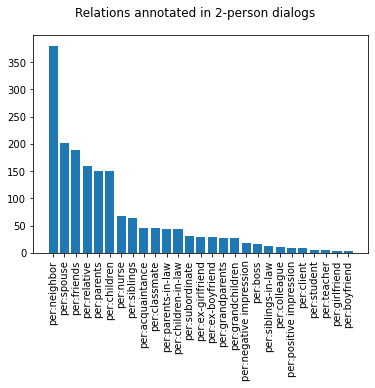

In [6]:
all_roles_list = sorted(all_roles.items(), key=lambda x:x[1],reverse=True)

ignore_relations = ['unanswerable','per:alternate_name']
all_roles_keys = [item[0] for item in all_roles_list if item[0] not in ignore_relations]
all_roles_values = [item[1] for item in all_roles_list if item[0] not in ignore_relations]

plt.xticks(rotation=90)
plt.bar(all_roles_keys,all_roles_values)

plt.suptitle("Relations annotated in 2-person dialogs")

In [97]:
all_roles_keys[0]

'unanswerable'

In [98]:
all_roles_keys[1]

'per:alternate_name'

In [91]:
sorted(all_roles.items(), key=lambda x:x[1],reverse=True)

[('unanswerable', 729),
 ('per:alternate_name', 524),
 ('per:neighbor', 380),
 ('per:spouse', 202),
 ('per:friends', 188),
 ('per:relative', 160),
 ('per:parents', 151),
 ('per:children', 151),
 ('per:nurse', 67),
 ('per:siblings', 64),
 ('per:acquaintance', 46),
 ('per:classmate', 46),
 ('per:parents-in-law', 43),
 ('per:children-in-law', 43),
 ('per:subordinate', 30),
 ('per:ex-girlfriend', 29),
 ('per:ex-boyfriend', 29),
 ('per:grandparents', 28),
 ('per:grandchildren', 28),
 ('per:negative impression', 18),
 ('per:boss', 17),
 ('per:siblings-in-law', 12),
 ('per:colleague', 10),
 ('per:positive impression', 9),
 ('per:client', 8),
 ('per:student', 6),
 ('per:teacher', 6),
 ('per:girlfriend', 4),
 ('per:boyfriend', 4)]

In [6]:
pair_dialog_df = [train_df[i] for i in pair_dialog_indices]

In [22]:
pair_dialog_df[2][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 1', 'y': '和平', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': 'S 2', 'y': '和平', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': '和平', 'y': 'S 1', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': '和平', 'y': 'S 2', 'r': ['per:alternate_name'], 'rid': [0]}]

In this example, it definitely looks like S1 is the parent-in-law, and S2 is the child-in-law, which seems consistent with the annotation order of (S2, S1). As in, <br/>
'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'] means <br/>
x is the parents-in-law of y <br/>
and <br/>
'x': 'S 2', 'y': 'S 1', 'r': ['per:children-in-law'] means <br/>
x is the children-in-law of y

Here, and in a few other examples, it looks like the relation annotation is in reverse order. From the dialogue, S2 says, "爸..." to S1, whereas the relation annotated is <br/>
<br/>
'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'] <br/>
<br/>
These examples, as well as the diagram in [this image](https://github.com/bistu-nlp-lab/CRECIL), leads me to believe that relations are annotated as "x is the per:_relation_ of y", or "S1 is the _parents-in-law_ of S2" <br/>
<br/>
With this, I can make a dataframe with variables= _text_, _speaker-addressee-relation_

In [8]:
pair_df = []

for item in pair_dialog_df:
    

    S1_title = ''
    S2_title = ''

    for rel in item[1]:

        if rel['x']=='S 1' and rel['y']=='S 2':

            S1_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S1_title)>0: 
                S1_title=S1_title[0]

        if rel['y']=='S 1' and rel['x']=='S 2':

            S2_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S2_title)>0: 
                S2_title=S2_title[0]

        if len(S1_title)>0 and len(S2_title)>0:

            S1_relation = S1_title+":"+S2_title
            S2_relation = S2_title+":"+S1_title

            for line in item[0]:
                party = re.findall('^S\s[1-2]',line)
                if len(party)>0: 
                    party=party[0]

                    if party =='S 1':
                        pair_df.append((line,S1_relation))
                    elif party=='S 2':
                        pair_df.append((line,S2_relation))

pair_df = pd.DataFrame(list(pair_df),columns=['text','relation'])

NameError: name 'pair_dialog_df' is not defined

In [9]:
Counter(pair_df.relation).most_common()

[('spouse:spouse', 9637),
 ('friends:friends', 5821),
 ('children-in-law:parents-in-law', 5705),
 ('parents-in-law:children-in-law', 5576),
 ('neighbor:neighbor', 4026),
 ('relative:relative', 2684),
 ('classmate:classmate', 2552),
 ('children:parents', 1178),
 ('parents:children', 1158),
 ('subordinate:nurse', 765),
 ('nurse:subordinate', 741),
 ('grandparents:grandchildren', 546),
 ('grandchildren:grandparents', 532),
 ('acquaintance:acquaintance', 504),
 ('siblings:siblings', 490)]

In [7]:
rel_dict = dict()
for rel in list(pair_df.relation.unique()):
    rel_dict[rel]=dict()
    rel_dict[rel]['你']=0
    rel_dict[rel]['您']=0

NameError: name 'pair_df' is not defined

In [10]:
for i in range(0,len(pair_df)):
        
    rel_dict[pair_df.relation.iloc[i]]['你'] += len(re.findall('你',pair_df.text.iloc[i]))
    rel_dict[pair_df.relation.iloc[i]]['您'] += len(re.findall('您',pair_df.text.iloc[i]))

In [11]:
#reverse the order of the nested keys in rel_dict
rel_dict_2 = dict()
rel_dict_2['你'] = dict()
rel_dict_2['您'] = dict()

for item in rel_dict:
    rel_dict_2['你'][item] = rel_dict[item]['你']
    rel_dict_2['您'][item] = rel_dict[item]['您']


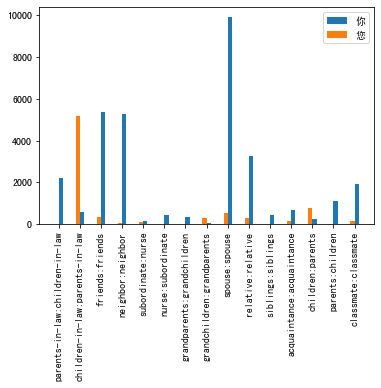

In [12]:
#try to graph the above
import matplotlib.pyplot as plt
from matplotlib import font_manager

plt.rcParams['font.sans-serif'] = ['SimHei']


fig, ax = plt.subplots()

ax.bar(rel_dict_2['你'].keys(), rel_dict_2['你'].values(), width=0.2, align='edge', label='你')
ax.bar(rel_dict_2['您'].keys(), rel_dict_2['您'].values(), width=-0.2, align='edge', label='您')


ax.legend()
plt.xticks(rotation=90)


fig.show()

I can use the Pearson’s Chi-Square test to test independence between the variables, in this case represented by the direction of speaker-to-addressee. This is analagous to the scenario tested [here](https://www.geeksforgeeks.org/python-pearsons-chi-square-test/)

In [13]:
#Present data as an observation table
rel_df = pd.DataFrame(rel_dict_2)
rel_df

,你,您
parents-in-law:children-in-law,2218,4
children-in-law:parents-in-law,588,5159
friends:friends,5387,353
neighbor:neighbor,5292,79
subordinate:nurse,172,100
nurse:subordinate,422,0
grandparents:grandchildren,320,0
grandchildren:grandparents,38,275
spouse:spouse,9910,512
relative:relative,3261,283


In [14]:
from scipy.stats import chi2_contingency

# defining the table
stat, p, dof, expected = chi2_contingency(rel_df)
 
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0)


Try to explore the other forms of data for more speaker information

In [19]:
train_df[0][0]

['S 1: 哟，志国回来啦',
 'S 2: 啊',
 'S 1: 唉唉唉，钥匙拿着了么？',
 'S 2: 拿着了',
 'S 1: 拿着啦！嘿！……唉你干嘛呐？',
 'S 2: 啊？',
 'S 1: 啊干嘛呀？',
 'S 2: 我爸在楼下拿晚报说话就回来，咱们趁这工夫，赶紧布置一下现场',
 'S 1: ……什么呀说什么呐？',
 'S 2: 我路上就想好了，咱要不把他哄顺溜了，他能把咱们留下么',
 'S 1: 唉唉唉，不是，你不是拿着钥匙了么？',
 'S 2: 是拿着了',
 'S 1: 啊两室一厅',
 'S 2: 没错两室一厅……',
 'S 1: 啊',
 'S 2: 跟人合住',
 'S 1: 什么？……怎么又改主意啦？不是说好了嘛？',
 'S 2: 是说好了，他又变了呀，他计划更好也赶不上变化呀……',
 'S 1: 唉你们单位领导怎么说话不算话呀……',
 'S 2: 谁说不是呢，当时气的我真想跟他们拼了',
 'S 1: 拼了没有啊？',
 'S 2: 我要拼了我还能在家擦地么我……不瞒你说，我们领导啊，侦察兵出身，奇袭白虎团的时候，他就跟着一块儿去了',
 'S 1: 嗨',
 'S 2: 打我这样儿的，一次八个……',
 'S 1: 那别跟人家拼了，那怎么办呐？爸说话就回来咱怎么跟爸说呀？',
 'S 2: 赶紧拿出点儿实际行动来吧，收拾收拾屋子呀……',
 'S 1: 唉唉……',
 'S 3: 这个志国回来啦',
 'S 2: 啊，回来了',
 'S 3: 啊……啊你们这干什么呐？',
 'S 1: 啊爸，您您歇着您的，我们归置归置----忒乱了',
 'S 3: 这个乱点好啊，舒服嘛',
 'S 2: 别介爸，还是归置归置吧',
 'S 3: 有什么好归置的？啊？就让它乱着吧，这些破烂我也不打算要了，志国',
 'S 2: 啊？',
 'S 3: 钥匙拿到没有',
 'S 2: 啊爸……',
 'S 3: 你们准备什么搬家呀？',
 'S 2: 我……',
 'S 3: 要不要我给你们联系一下搬家公司，只要打个电话，他们是随叫随到',
 'S 2: 爸不忙不忙不忙……',
 'S 3: 不忙啊？我可忙',
 'S 1: 啊？',
 'S 3: 等你们搬走了以后，我还得找人，装修房子，买家具重新布置房子，我可是有点儿等不及了

In [2]:
%ls ../CRECIL/My_home_data/ 

exportCRT.py  final.json                     Untitled.ipynb
final_0.json  final_with_speaker_names.json


In [25]:
%less ../CRECIL/My_home_data/final.json

In [3]:
with open('../CRECIL/My_home_data/final_with_speaker_names.json','r') as infile:
    final_with_speaker_names = json.loads(infile.read())
 

In [4]:
final_with_speaker_names[0][1]

[{'x': '贾圆圆', 'y': '贾志国', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾圆圆', 'y': '贾志新', 'r': ['per:relative'], 'rid': [29]},
 {'x': '贾圆圆', 'y': '贾小凡', 'r': ['per:relative'], 'rid': [29]},
 {'x': '贾圆圆', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾圆圆', 'y': '傅明', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': '贾圆圆', 'y': '小张', 'r': ['unanswerable'], 'rid': [31]},
 {'x': '贾圆圆', 'y': '二哥', 'r': ['per:relative'], 'rid': [29]},
 {'x': '贾圆圆', 'y': '孩子', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': '贾圆圆', 'y': '老同志', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': '贾圆圆', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾志国', 'y': '贾圆圆', 'r': ['per:parents'], 'rid': [2]},
 {'x': '贾志国', 'y': '贾志新', 'r': ['per:siblings'], 'rid': [22]},
 {'x': '贾志国', 'y': '贾小凡', 'r': ['per:siblings'], 'rid': [22]},
 {'x': '贾志国', 'y': '和平', 'r': ['per:spouse'], 'rid': [23]},
 {'x': '贾志国', 'y': '傅明', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾志国', 'y': '小张', 'r': ['unanswerable'], 'rid': [

In [4]:
with open('../CRECIL/My_home_data/final.json','r') as infile:
    final_json = json.loads(infile.read())

In [86]:
final_json[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1', 'y': 'S 3', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': 'S 4', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': 'S 5', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1', 'y': 'S 6', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': 'S 1', 'y': '小张', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1', 'y': '二哥', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1', 'y': '孩子', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': 'S 1', 'y': '老同志', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': 'S 1', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:siblings'], 'rid': [22]},
 {'x': 'S 2', 'y': 'S 4', 'r': ['per:siblings'], 'rid': [22]},
 {'x': 'S 2', 'y': 'S 5', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 6', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': '小张', 'r': ['unanswerable'], 'rid

The following label is troubling. How can one be both the subordinate and boss of another? <br/>
 {'x': '小张',
  'y': 'S 3',
  'r': ['per:nurse', 'per:subordinate', 'per:boss'],
  'rid': [14, 20, 21]}, <br/>
  S3 is 二哥. 二哥 isn't listed anywhere as a real entity...

In [119]:
#task: get all alternate_names from final_json
pattern = re.compile('S\s[0-9]')
x = []
y = []
r = []
for i in range(0,len(final_json)):
    temp = final_json[i][1]
    
    for item in temp:
        if (not bool(re.findall(pattern,item['x']))) and \
        (not bool(re.findall(pattern,item['y']))) and \
        (item['r'][0]=='per:alternate_name'):
            x.append(item['x'])
            y.append(item['y'])
            r.append(item['r'])
alt_names = pd.DataFrame(list(zip(x,y,r)),columns=['x','y','r'])

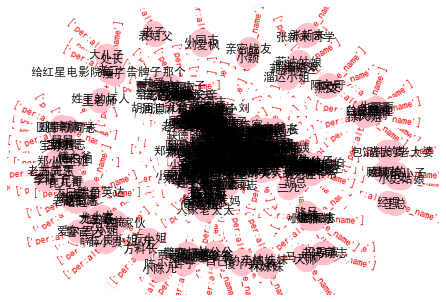

In [121]:
G = nx.Graph()
G.add_nodes_from([item for item in set(alt_names.x)])
G.add_edges_from([(alt_names.x.iloc[i],alt_names.y.iloc[i]) for i in range(0,len(alt_names))])
edge_labs = dict()
for i in range(0,len(alt_names)):
    edge_labs[(alt_names.x.iloc[i],alt_names.y.iloc[i])] = alt_names.r.iloc[i] 

plt.rcParams['font.sans-serif'] = ['SimHei']

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= edge_labs,
    font_color='red'
)
plt.axis('off')
plt.show()

There is an issue of a lot of overlap. It looks like some of these might be scene-specific. For example, 先生 is overloaded. <br/>
<br/>
Maybe not all is lost. What if I start out with a list of the main characters and use them as keys?

In [5]:
all_relations

NameError: name 'all_relations' is not defined

In [134]:
duplicates = all_relations[all_relations['relation']=='per:alternate_name']

Great, there are not duplicated left and right

In [135]:
duplicates

,A,B,relation
0,小晴,表妹,per:alternate_name
4,小许,许警察,per:alternate_name
43,老和,和平的母亲,per:alternate_name
91,余大妈,于大妈,per:alternate_name
92,小余,于大妈,per:alternate_name
101,刘建军,小刘,per:alternate_name
102,王佳,扣子,per:alternate_name
111,胡三,胡总,per:alternate_name
121,小陈儿,陈小红,per:alternate_name
159,陈爱兰,陈大妈,per:alternate_name


In [115]:
alt_name_sorted = pd.DataFrame(alt_name_sorted,columns=['x','y'])
len(alt_name_sorted)

2538

In [116]:
alt_name_uniq = alt_name_sorted.drop_duplicates()
len(alt_name_uniq)

837

In [107]:
alt_names.head()

,x,y,r
0,于大妈,小于,[per:alternate_name]
1,小于,于大妈,[per:alternate_name]
2,小凡姐,小凡,[per:alternate_name]
3,小凡姐,小姑,[per:alternate_name]
4,小凡,小凡姐,[per:alternate_name]


In [29]:
test_relations_list = final_json[0][1]
x = [item['x'] for item in test_relations_list]
y = [item['y'] for item in test_relations_list]
r = [item['r'][0] for item in test_relations_list]
df1 = pd.DataFrame(list(zip(x,y,r)),columns=['x','y','r'])

In [30]:
print(len(df1))
df1.head()

110


,x,y,r
0,S 1,S 2,per:children
1,S 1,S 3,per:relative
2,S 1,S 4,per:relative
3,S 1,S 5,per:children
4,S 1,S 6,per:grandchildren


In [67]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df1)

       x    y                    r
0    S 1  S 2         per:children
1    S 1  S 3         per:relative
2    S 1  S 4         per:relative
3    S 1  S 5         per:children
4    S 1  S 6    per:grandchildren
5    S 1   小张         unanswerable
6    S 1   二哥         per:relative
7    S 1   孩子   per:alternate_name
8    S 1  老同志    per:grandchildren
9    S 1   和平         per:children
10   S 2  S 1          per:parents
11   S 2  S 3         per:siblings
12   S 2  S 4         per:siblings
13   S 2  S 5           per:spouse
14   S 2  S 6         per:children
15   S 2   小张         unanswerable
16   S 2   二哥         per:siblings
17   S 2   孩子          per:parents
18   S 2  老同志         per:children
19   S 2   和平           per:spouse
20   S 3  S 1         per:relative
21   S 3  S 2         per:siblings
22   S 3  S 4         per:siblings
23   S 3  S 5         per:relative
24   S 3  S 6         per:children
25   S 3   小张      per:subordinate
26   S 3   二哥   per:alternate_name
27   S 3   孩子       

In [6]:
with open('../CRECIL/Orginal_data/My_home.json','r') as infile:
    original_df = json.loads(infile.read())

In [52]:
Counter(df1.r)

Counter({'per:children': 14,
         'per:relative': 24,
         'per:grandchildren': 4,
         'unanswerable': 8,
         'per:alternate_name': 8,
         'per:parents': 14,
         'per:siblings': 10,
         'per:spouse': 4,
         'per:subordinate': 2,
         'per:children-in-law': 4,
         'per:grandparents': 4,
         'per:parents-in-law': 4,
         'per:nurse': 10})

In [37]:
exclude_list = ['S 1','S 2', 'S 3', 'S 4', 'S 5', 'S 6']
df2 = df1[(~df1['x'].isin(exclude_list))&(~df1['y'].isin(exclude_list))]

In [40]:
df3 = df1[(df1['x'].isin(exclude_list))&(df1['y'].isin(exclude_list))]

In [47]:
df4 = df1[(df1['x'].isin(exclude_list))&(~df1['y'].isin(exclude_list))]

In [48]:
df5 = df1[(~df1['x'].isin(exclude_list))&(df1['y'].isin(exclude_list))]

In [57]:
df6 = df4[df4['r']=='per:alternate_name']

In [58]:
df6

,x,y,r
7,S 1,孩子,per:alternate_name
26,S 3,二哥,per:alternate_name
49,S 5,和平,per:alternate_name
58,S 6,老同志,per:alternate_name


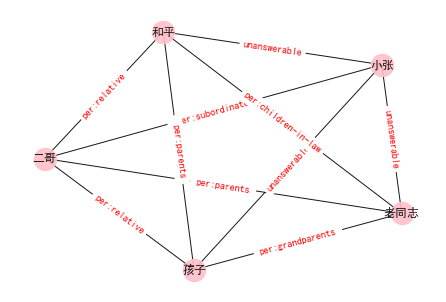

In [39]:
G = nx.Graph()
G.add_nodes_from([item for item in set(df2.x)])
G.add_edges_from([(df2.x.iloc[i],df2.y.iloc[i]) for i in range(0,len(df2))])
edge_labs = dict()
for i in range(0,len(df2)):
    edge_labs[(df2.x.iloc[i],df2.y.iloc[i])] = df2.r.iloc[i] 

plt.rcParams['font.sans-serif'] = ['SimHei']

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= edge_labs,
    font_color='red'
)
plt.axis('off')
plt.show()

In [63]:
all_relations[all_relations['A']=='和平']

,A,B,relation
7,和平,许警察,per:acquaintance
19,和平,小许,per:client
59,和平,孟朝阳,per:acquaintance
85,和平,于大妈,per:neighbor
112,和平,李大妈,per:friends
163,和平,陈大妈,per:neighbor
187,和平,东北汉,per:client
188,和平,工人,per:client
221,和平,贾小凡,per:relative
244,和平,贾志新,per:relative


It looks like there needs to be unique character ids. There might be more than one name referring to a given character (e.g. 先生), but those can always be disallowed from the final analysis. 

In [90]:
all_relations[all_relations['relation']=='per:alternate_name']

,A,B,relation
0,小晴,表妹,per:alternate_name
4,小许,许警察,per:alternate_name
43,老和,和平的母亲,per:alternate_name
91,余大妈,于大妈,per:alternate_name
92,小余,于大妈,per:alternate_name
101,刘建军,小刘,per:alternate_name
102,王佳,扣子,per:alternate_name
111,胡三,胡总,per:alternate_name
121,小陈儿,陈小红,per:alternate_name
159,陈爱兰,陈大妈,per:alternate_name


There are actually only 18 here, leading me to think there might actually be more in the raw data. 

New task: use the above two data sets to extract all relations line by line, and find a way to identify directed speech. 

**Stats about Original data** 
- 120 episodes

In [9]:
len(original_df['episodes'][0]['scenes'])

4

The original transcripts might provide more available data than the final. It shows speaker, line ID and character_entities, which are entities mentionned in the utterance. However, it might sometimes be the case the speaker is speaking about that entity in the 3rd person. Also, relations are not listed here, but could be linked from the final data.

##### Subtask
Get relationship mappings of all characters in the show

In [11]:
with open('../CRECIL/Orginal_data/relation/relation.txt','r') as infile:
    relations_txt = infile.read()
relations_txt.split('\n')[0:5]

["('小晴', '表妹')\t['per:alternate_name']",
 "('大壮', '秀芳')\t['per:children']",
 "('秀芳', '大壮')\t['per:parents']",
 "('许警察', '于大妈')\t['per:acquaintance']",
 "('小许', '许警察')\t['per:alternate_name']"]

In [60]:
#Put into pandas format. Remember that the relation is A is stated relation (e.g. parent) of B
#test = "('小晴', '表妹')\t['per:alternate_name']"
#re.findall("'.*?'",test)[2]

A = []
B = []
relations = []
pattern = re.compile("'.*?'")
for line in relations_txt.split('\n'):
    if len(line)>0:
        A.append(pattern.findall(line)[0].replace("'",""))
        B.append(pattern.findall(line)[1].replace("'",""))
        relations.append(pattern.findall(line)[2].replace("'",""))
all_relations = pd.DataFrame(list(zip(A,B,relations)),columns = ['A','B','relation'])
all_relations.head()

,A,B,relation
0,小晴,表妹,per:alternate_name
1,大壮,秀芳,per:children
2,秀芳,大壮,per:parents
3,许警察,于大妈,per:acquaintance
4,小许,许警察,per:alternate_name


In [61]:
len(all_relations)

468

In [56]:
Counter(all_relations.A).most_common(20)

[('贾志新', 30),
 ('和平', 29),
 ('贾圆圆', 26),
 ('傅明', 26),
 ('贾志国', 22),
 ('燕红', 16),
 ('于大妈', 14),
 ('薛小桂', 14),
 ('张凤姑', 14),
 ('贾小凡', 12),
 ('老胡', 11),
 ('和平的母亲', 10),
 ('孟朝阳', 9),
 ('陈大妈', 9),
 ('纪春生', 8),
 ('小晴', 7),
 ('老胡妻子', 7),
 ('杨大夫', 6),
 ('老郑', 6),
 ('方方', 5)]

In [34]:
import networkx as nx

In [48]:
G = nx.Graph()
G.add_nodes_from([item for item in set(all_relations.A)])
G.add_edges_from([(all_relations.A.iloc[i],all_relations.B.iloc[i]) for i in range(0,len(all_relations))])

In [54]:
edge_labs = dict()
for i in range(0,len(all_relations)):
    edge_labs[(all_relations.A.iloc[i],all_relations.B.iloc[i])] = all_relations.relation.iloc[i] 

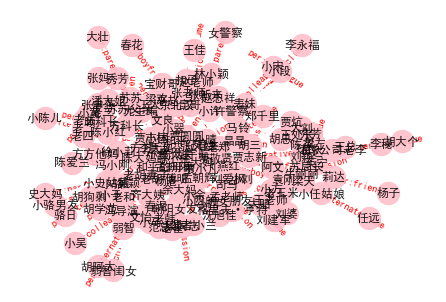

In [55]:
from matplotlib import font_manager

plt.rcParams['font.sans-serif'] = ['SimHei']

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= edge_labs,
    font_color='red'
)
plt.axis('off')
plt.show()

In [71]:
list_a = [item[0] for item in Counter(all_relations.A).most_common(8)]
list_b = [item[0] for item in Counter(all_relations.B).most_common(8)]
some_relations = all_relations[all_relations.A.isin(list_a)&all_relations.B.isin(list_b)] 

In [73]:
some_relations

,A,B,relation
74,薛小桂,于大妈,per:neighbor
76,于大妈,贾志新,per:neighbor
77,贾志新,于大妈,per:neighbor
78,贾圆圆,于大妈,per:neighbor
79,于大妈,贾圆圆,per:neighbor
80,于大妈,燕红,per:neighbor
81,燕红,于大妈,per:neighbor
84,于大妈,和平,per:neighbor
85,和平,于大妈,per:neighbor
86,贾志国,于大妈,per:neighbor


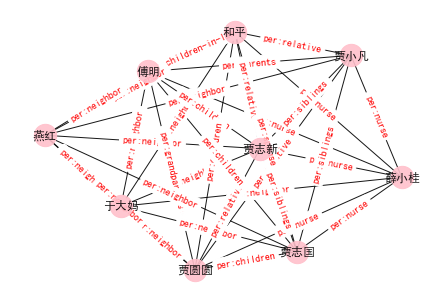

In [72]:
G = nx.Graph()
G.add_nodes_from([item for item in set(some_relations.A)])
G.add_edges_from([(some_relations.A.iloc[i],some_relations.B.iloc[i]) for i in range(0,len(some_relations))])
edge_labs = dict()
for i in range(0,len(some_relations)):
    edge_labs[(some_relations.A.iloc[i],some_relations.B.iloc[i])] = some_relations.relation.iloc[i] 

plt.rcParams['font.sans-serif'] = ['SimHei']

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= edge_labs,
    font_color='red'
)
plt.axis('off')
plt.show()

##### Subtask
Find sentences in original data between known relationships

In [17]:
all_relations.head()

,A,B,relation
0,小晴,表妹,per:alternate_name
1,大壮,秀芳,per:children
2,秀芳,大壮,per:parents
3,许警察,于大妈,per:acquaintance
4,小许,许警察,per:alternate_name


In [15]:
original_df['episodes'][0]['scenes'][0]['utterances'][0]['speakers']

'圆圆'

In [16]:
original_df['episodes'][0]['scenes'][0]['utterances'][0]['transcript']

'爸，动画片儿哪频道啊？'

In [12]:
original_df['episodes'][0]['scenes'][0]['utterances'][0]['tokens']

{'utterance_id': 'ep1_sc1_u1',
 'speakers': '圆圆',
 'transcript': '爸，动画片儿哪频道啊？',
 'tokens': ['爸', '，', '动画片儿', '哪', '频道', '啊', '？', ''],
 'character_entities': [['爸', 'jzg', 0]]}

In [14]:
original_df['episodes'][0]['scenes'][0]['utterances'][0]['character_entities'][0]

['爸', 'jzg', 0]

In [8]:
s1 = []
s2 = []
relation = []
utterance = []


for ep in tqdm(original_df['episodes']):
    for sc in ep['scenes']:
        for utt in sc['utterances']:
            if utt['speakers'] in list(all_relations.A):
                
                if len(utt['character_entities'])>0:
                    for token in utt['character_entities'][0]:
                        if token in list(all_relations.B):
                           
                            if len(all_relations[(all_relations['A']==utt['speakers'])&(all_relations['B']==token)].relation)>0:
                                
                                #Rules for assuming that the utterance is spoken directly to 
                                #another individual:
                                #1. an annotated relation exists between speakers
                                #2. a 你 or 您 exists in the phrase
                                if ('你' in utt['tokens']) or ('您' in utt['tokens']):

                                    s1.append(utt['speakers'])
                                    s2.append(token)
                                    relation.append(all_relations[(all_relations['A']==utt['speakers'])&(all_relations['B']==token)].relation.item())
                                    utterance.append(utt['transcript'])
                                    
                                   
                   
          

100%|████████████████████████████████████████| 120/120 [00:01<00:00, 112.28it/s]


In [9]:
orig_pair_df = pd.DataFrame(list(zip(s1,s2,relation,utterance)),columns=['S1','S2','Relation','Transcript'])
orig_pair_df = orig_pair_df.drop_duplicates()
print(len(orig_pair_df))
orig_pair_df.head(20)

262


,S1,S2,Relation,Transcript
0,燕红,老郑,per:children,你别闹啦。也不知道谁这么缺德，把这玩艺儿贴得满大街都是……打中午我们家就没断了来人，如今那队...
1,燕红,老郑,per:children,那我也只骗你一人啊，你这连我爸都捎上啦。
2,燕红,贾志新,per:neighbor,我干涉你？贾志新你从小到大就没少干涉我的恋爱自由，这么些年我就没计较过！
3,燕红,袁刚,per:ex-girlfriend,初三！4班的袁刚跟我交朋友，被人暴打一顿再也不敢理我了，这事是你找人干的吧？
5,燕红,王老师,per:student,我高一的时候，和教体育的王老师通信，被你报告学校，害得王老师调离，我在学校里抬不起头，这也是...
7,燕红,晶晶,per:positive impression,听说你今天请女朋友吃饭，我一直在里面帮厨呢。这位就是杨晶晶同志吧？一直听志新念叨，夸你内外兼...
8,燕红,晶晶,per:positive impression,对，他偷的都是我家的。另外，他聪明、热情、好学、好色……优点多得说不完。你能得到他的心，真是...
9,晶晶,燕红,per:negative impression,不！我和他并不般配。大姐，其实你和他才是最般配！你对他最了解，也最关心，这是一个女孩子的直觉...
10,和平,和平的母亲,per:children,妈，妈，没人接您，是我自个打的接您。
11,老和,和平的母亲,per:alternate_name,妈知道，妈是送你个人情。


There is still a problem in the above data, i.e., it's not obvious that each line is actually directed towards the entity listed and not referring to that person in the 3rd person. For example <br/>
燕红	王老师	per:student	我高一的时候，和教体育的王老师通信，被你报告学校，害得王老师调离，我在学校里抬不起头，这也是..

Also a mystery: how do we go from so many episodes to so few actual lines?

In [11]:
Counter(orig_pair_df.Relation).most_common()

[('per:neighbor', 67),
 ('per:spouse', 43),
 ('per:children', 41),
 ('per:parents', 32),
 ('per:friends', 13),
 ('per:classmate', 12),
 ('per:client', 9),
 ('per:alternate_name', 6),
 ('per:acquaintance', 6),
 ('per:ex-girlfriend', 4),
 ('per:parents-in-law', 4),
 ('per:girlfriend', 4),
 ('per:relative', 4),
 ('per:boss', 3),
 ('per:nurse', 3),
 ('per:positive impression', 2),
 ('per:negative impression', 2),
 ('per:colleague', 2),
 ('per:dates', 2),
 ('per:student', 1),
 ('per:subordinate', 1),
 ('per:ex-boyfriend', 1)]

In [14]:
train_df[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 1', 'y': 'S 3', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': 'S 1', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1', 'y': '志国', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 2', 'y': '志国', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': 'S 3', 'y': 'S 1', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 3', 'y': 'S 2', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 3', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 3', 'y': '志国', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 4', 'y': 'S 1', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': 'S 2', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': 'S 3', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': '志国', 'r': ['unanswerable'], 'ri

In [49]:
all_relations[(all_relations['A']==utt['speakers'])&(all_relations['B']==token)].relation.item()

'per:children'

In [10]:
%less ../CRECIL/Orginal_data/My_home.json

In [7]:
%ls ../CRECIL/My_home_data/

exportCRT.py  final.json                     Untitled.ipynb
final_0.json  final_with_speaker_names.json


In [2]:
with open('../CRECIL/My_home_data/final_with_speaker_names.json','r') as infile:
    final_with_speaker_names = json.loads(infile.read())

In [11]:
final_with_speaker_names[0]

[['贾圆圆: 爸，动画片儿哪频道啊？',
  '贾志国: 看哪门子动画片呀----看连续剧',
  '贾志新: 小张你这菜可咸点儿啊！',
  '贾小凡: 二哥，你霸着鸡腿儿你一人吃你能不咸嘛你，人家一礼拜可才见一回晕腥！唉唉唉，动物世界动物世界……',
  '和平: 哎哎哎，咱爸今儿是怎么回事儿？从单位一回来就打蔫儿，饭都不吃就楼底下溜达去了这大冷的天儿……',
  '贾志新: 可能是添什么心事了，唉，是不是今儿跟单位巧遇哪位中午丧偶的女同志……',
  '和平: 说话不着调……',
  '贾志新: 咱妈去世两年多了，咱爸论条件，论身体，要为这烦恼，那还不要多正常有多正常？',
  '贾小凡: 咱爸这岁数……不至于……',
  '贾圆圆: 爱情不分老少，人生没有单行道。',
  '和平: 嘿嘿嘿，这孩子哪儿学来这么些乱七八糟的……',
  '贾志国: 还不都是你们招的！咱爸上了一天班，累了，躺会儿，你们就非说他老人家惦记给咱们找后妈，这是那儿跟那儿啊！',
  '贾圆圆: 姑姑，你说大人为什么都这么愿意上班啊？',
  '贾小凡: 啊也不是所有的大人都愿意上班--比如你二叔，在家闲了三年他都不着急……',
  '贾志新: 谁闲着了？我挂着两个单位，兼着三个公司的副总经理，我比谁不忙呀！',
  '贾小凡: 啊呸！你忙！咱爸他们单位，已经好几次想把爸的办公桌从局长室请出去啦！',
  '和平: 可你爸也是，反正也退了，挨家享两天轻福不好么！何必每星期还大老远的跑到局里去“顾问”两次--害得人家车接车送的，给国家省点儿气油好不好？',
  '贾志国: 老同志嘛，工作需要嘛！',
  '和平: 你算了吧！你爸呀，纯属老糊涂了！',
  '贾志新: 还不光是老……那是他们别人，咱爸可是越老越明白！',
  '贾小凡: 根本不可能……那是绝对没错儿！我就同意二哥这观点！',
  '贾志国: 我就反对你们这样……谁反对你们我就反对谁！',
  '和平: 唉唉你们今天怎么了？平常你们不总说咱爸……',
  '贾志国: 没有！根本没有！和平，你在背后不也总说咱爸是个明白人吗？',
  '和平: 我那是哄着他玩儿哪！',
  '贾圆圆: 妈！爷爷……',
  '和平: 爷爷怎么啦？爷爷有缺点就不许人说呀？……可不嘛，有缺点你说，没缺点你什么呀？不是我批评你们，背后议论人这毛病你们

Needs to be simplified. Only keep names as they appear in the script.

In [11]:
len(final_with_speaker_names[0][1])

108

In [12]:
final_with_speaker_names[0][0]

['贾圆圆: 爸，动画片儿哪频道啊？',
 '贾志国: 看哪门子动画片呀----看连续剧',
 '贾志新: 小张你这菜可咸点儿啊！',
 '贾小凡: 二哥，你霸着鸡腿儿你一人吃你能不咸嘛你，人家一礼拜可才见一回晕腥！唉唉唉，动物世界动物世界……',
 '和平: 哎哎哎，咱爸今儿是怎么回事儿？从单位一回来就打蔫儿，饭都不吃就楼底下溜达去了这大冷的天儿……',
 '贾志新: 可能是添什么心事了，唉，是不是今儿跟单位巧遇哪位中午丧偶的女同志……',
 '和平: 说话不着调……',
 '贾志新: 咱妈去世两年多了，咱爸论条件，论身体，要为这烦恼，那还不要多正常有多正常？',
 '贾小凡: 咱爸这岁数……不至于……',
 '贾圆圆: 爱情不分老少，人生没有单行道。',
 '和平: 嘿嘿嘿，这孩子哪儿学来这么些乱七八糟的……',
 '贾志国: 还不都是你们招的！咱爸上了一天班，累了，躺会儿，你们就非说他老人家惦记给咱们找后妈，这是那儿跟那儿啊！',
 '贾圆圆: 姑姑，你说大人为什么都这么愿意上班啊？',
 '贾小凡: 啊也不是所有的大人都愿意上班--比如你二叔，在家闲了三年他都不着急……',
 '贾志新: 谁闲着了？我挂着两个单位，兼着三个公司的副总经理，我比谁不忙呀！',
 '贾小凡: 啊呸！你忙！咱爸他们单位，已经好几次想把爸的办公桌从局长室请出去啦！',
 '和平: 可你爸也是，反正也退了，挨家享两天轻福不好么！何必每星期还大老远的跑到局里去“顾问”两次--害得人家车接车送的，给国家省点儿气油好不好？',
 '贾志国: 老同志嘛，工作需要嘛！',
 '和平: 你算了吧！你爸呀，纯属老糊涂了！',
 '贾志新: 还不光是老……那是他们别人，咱爸可是越老越明白！',
 '贾小凡: 根本不可能……那是绝对没错儿！我就同意二哥这观点！',
 '贾志国: 我就反对你们这样……谁反对你们我就反对谁！',
 '和平: 唉唉你们今天怎么了？平常你们不总说咱爸……',
 '贾志国: 没有！根本没有！和平，你在背后不也总说咱爸是个明白人吗？',
 '和平: 我那是哄着他玩儿哪！',
 '贾圆圆: 妈！爷爷……',
 '和平: 爷爷怎么啦？爷爷有缺点就不许人说呀？……可不嘛，有缺点你说，没缺点你什么呀？不是我批评你们，背后议论人这毛病你们也该改改啦！要不咱爸是明白人，不往心里去，要不然……呦

In [14]:
main_names = set()
for line in final_with_speaker_names[0][0]:
    name = line.split(': ')[0]
    main_names.add(name)
main_names

{'傅明', '和平', '贾圆圆', '贾小凡', '贾志国', '贾志新'}

In [ ]:
#Reset to original

In [33]:
alt_names = dict()
alt_names_list = []
for item in final_with_speaker_names[0][1]:
    if item['r'][0]=='per:alternate_name' and item['x'] in main_names:
        if item['x'] not in alt_names:
            alt_names[item['x']] = []
        alt_names[item['x']].append(item['y'])
        alt_names_list.append(item['y'])

In [39]:
new_list = []
new_list_set = set()
two_person_d = []

for item in final_with_speaker_names[0][1]:
    if item['x'] in main_names:
        if (item['y'] in main_names):
            test = (item['x'],item['y'],item['r'][0])
            if test not in new_list_set:
                new_list.append(item)
                new_list_set.add(test)
        elif item['y'] not in alt_names_list:
            test = (item['x'],item['y'],item['r'][0])
            if test not in new_list_set:
                new_list.append(item)
                new_list_set.add(test)
len(new_list)

36

In [12]:
alt_names = dict()
all_main_names = set()
two_person_d = []

for i in range(0,len(final_with_speaker_names)):
    
    main_names = set()
    for line in final_with_speaker_names[i][0]:
        name = line.split(': ')[0]
        main_names.add(name)
        all_main_names.add(name)

    alt_names_list = []
    for item in final_with_speaker_names[i][1]:
        if item['r'][0]=='per:alternate_name' and item['x'] in main_names:
            if item['x'] not in alt_names:
                alt_names[item['x']] = []
            alt_names[item['x']].append(item['y'])
            alt_names_list.append(item['y'])    
            
    new_list = []
    new_list_set = set()
    names_with_rels = set()
    for item in final_with_speaker_names[0][1]:
        if item['x'] in main_names:
            if (item['y'] in main_names):
                test = (item['x'],item['y'],item['r'][0])
                if test not in new_list_set:
                    new_list.append(item)
                    new_list_set.add(test)
                    names_with_rels.add(item['x'])
            elif item['y'] not in alt_names_list:
                test = (item['x'],item['y'],item['r'][0])
                if test not in new_list_set:
                    new_list.append(item)
                    new_list_set.add(test)
                    names_with_rels.add(item['x'])
                    
    final_with_speaker_names[i][1] = new_list
    
    #store no. speakers in dialogue in new field
    final_with_speaker_names[i].append(len(main_names))
    final_with_speaker_names[i].append(main_names)
    
    main_relations = []
    new_list_set = set()
    for name in main_names:
        if name in [item['x'] for item in new_list]:
            candidates = [item for item in new_list if ((item['x'] in main_names) and \
                                                        (item['y'] in main_names))]
            test = (item['x'],item['y'],item['r'][0])
            if test not in new_list_set:
                main_relations.extend(candidates)
                new_list_set.add(test)
        
    final_with_speaker_names[i].append(main_relations)
    
    known_ppl = True
    if len(main_names.difference(names_with_rels))==0 and len(main_names)==2:
        two_person_d.append(i)

In [44]:
main_relations

[{'x': '贾圆圆', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾圆圆', 'y': '傅明', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': '和平', 'y': '贾圆圆', 'r': ['per:parents'], 'rid': [2]},
 {'x': '和平', 'y': '傅明', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': '傅明', 'y': '贾圆圆', 'r': ['per:grandparents'], 'rid': [24]},
 {'x': '傅明', 'y': '和平', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': '贾圆圆', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾圆圆', 'y': '傅明', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': '和平', 'y': '贾圆圆', 'r': ['per:parents'], 'rid': [2]},
 {'x': '和平', 'y': '傅明', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': '傅明', 'y': '贾圆圆', 'r': ['per:grandparents'], 'rid': [24]},
 {'x': '傅明', 'y': '和平', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': '贾圆圆', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾圆圆', 'y': '傅明', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': '和平', 'y': '贾圆圆', 'r': ['per:parents'], 'rid': [2]},
 {'x': '和平', 'y': '傅明', 'r': ['per

In [48]:
len(two_person_d)

75

In [39]:
two_person_d[2]

11

In [13]:
final_with_speaker_names[11]

[['贾志新: 打开国门的同时，怎么把苍蝇也放进来啦？学习外国是好事儿，学人家先进技术，学人家管理经验，你不能什么都学啊！人家外国人还光着身子在大街上溜达呢，你们也学？愚人节，是外国人吃饱了没事儿干想出来的馊主意，咱们连温饱问题都没解决，学那干嘛？瞧弄我这一嘴肥皂沫子……还笑你们。',
  '贾小凡: 二哥别生气啦，骗你吃肥皂总比骗你在外头干冻一个钟头强吧？',
  '贾志新: 不要转移斗争大方向，那是刘颖打电话来……唔，会不会拿我开涮哪？',
  '贾小凡: 还用问？也不看看今儿是什么日子？让我说呀，这人还算照顾你，没让你穿着背心裤衩上外头罚站去！',
  '贾志新: 刘颖绝干不出这种缺德事……是谁呢？她肯定得躲在附近偷偷乐……郑燕红！不是她干的我嗑死。只有她知道我和小颖的关系，中学的时侯她就想拆散我们，今儿肯定是阶级报复……我找她算账去！',
  '贾小凡: 别，哥你听我说，大“愚人节”的显得咱气量太小可不行——咱给她来个以其人之道还治其人之身。',
  '贾志新: 让她也上一当？唔，干这个我拿手儿……有了，咱给她换房！',
  '贾小凡: 换房？',
  '贾志新: 小凡，圆圆，我说，你们写，我要不让她们家挤破了头算我没能耐！',
  '贾志新: 写'],
 [{'x': '贾志新', 'y': '贾圆圆', 'r': ['per:relative'], 'rid': [29]},
  {'x': '贾志新', 'y': '贾志国', 'r': ['per:siblings'], 'rid': [22]},
  {'x': '贾志新', 'y': '贾小凡', 'r': ['per:siblings'], 'rid': [22]},
  {'x': '贾志新', 'y': '和平', 'r': ['per:relative'], 'rid': [29]},
  {'x': '贾志新', 'y': '傅明', 'r': ['per:children'], 'rid': [1]},
  {'x': '贾志新', 'y': '小张', 'r': ['per:subordinate'], 'rid': [20]},
  {'x': '贾小凡', 'y': '贾圆圆', 'r': ['per:relative'], 'rid': [29]},
  {'x': '贾小凡'

In [51]:
type(final_with_speaker_names)

list

In [32]:
with open('../CRECIL/My_home_data/final_with_speaker_names_clean.pickle','wb') as outfile:
    pickle.dump(final_with_speaker_names,outfile,protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../CRECIL/My_home_data/two_person_d.pickle','wb') as outfile:
    pickle.dump(two_person_d,outfile,protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('../CRECIL/My_home_data/final_with_speaker_names_clean.pickle', 'rb') as infile:
    final_with_speaker_names = pickle.load(infile)
    
with open('../CRECIL/My_home_data/two_person_d.pickle','rb') as infile:
    two_person_d = pickle.load(infile)

In [16]:
final_with_speaker_names[11][4]

[{'x': '贾志新', 'y': '贾小凡', 'r': ['per:siblings'], 'rid': [22]},
 {'x': '贾小凡', 'y': '贾志新', 'r': ['per:siblings'], 'rid': [22]}]

Question: how many people are there per relation in 2-person dialogues?

Relations found in `final_with_speaker_names[i][4]`

In [20]:
dialog_rel_dict = dict()
ch_set = set()

#One instance is a left-hand-side and right-hand-side of a relation
for i in two_person_d:
    
    for info in final_with_speaker_names[i][4]:

        r = info['r'][0]

        if r not in dialog_rel_dict:
            dialog_rel_dict[r] = [] 

        (x,y) = (info['x'],info['y'])
        
        ch_set.add(x)
        ch_set.add(y)
        
        if (x,y) not in dialog_rel_dict[r]:
            dialog_rel_dict[r].append((x,y))

In [21]:
dialog_rel_dict

{'per:children': [('贾志新', '傅明'),
  ('贾小凡', '傅明'),
  ('贾志国', '傅明'),
  ('贾圆圆', '和平'),
  ('贾圆圆', '贾志国')],
 'per:parents': [('傅明', '贾志新'),
  ('傅明', '贾小凡'),
  ('傅明', '贾志国'),
  ('和平', '贾圆圆'),
  ('贾志国', '贾圆圆')],
 'per:relative': [('贾圆圆', '贾小凡'),
  ('贾小凡', '贾圆圆'),
  ('贾志新', '和平'),
  ('和平', '贾志新'),
  ('贾圆圆', '贾志新'),
  ('贾志新', '贾圆圆')],
 'per:siblings': [('贾志新', '贾小凡'), ('贾小凡', '贾志新')],
 'per:spouse': [('贾志国', '和平'), ('和平', '贾志国')],
 'per:grandchildren': [('贾圆圆', '傅明')],
 'per:grandparents': [('傅明', '贾圆圆')],
 'per:children-in-law': [('和平', '傅明')],
 'per:parents-in-law': [('傅明', '和平')]}

Question: for each individual in 2-person dialogues, how many relations do they speak in?

In [25]:
ch_dict = dict()

for ch in ch_set:
    if ch not in ch_dict:
        ch_dict[ch]=dict()
    for r in dialog_rel_dict.keys():
        
        for pair in dialog_rel_dict[r]:
            
            if pair[0]==ch:
                
                if r not in ch_dict[ch]:
                    ch_dict[ch][r] = []
                    
                ch_dict[ch][r].append(pair)

In [26]:
ch_dict

{'傅明': {'per:parents': [('傅明', '贾志新'), ('傅明', '贾小凡'), ('傅明', '贾志国')],
  'per:grandparents': [('傅明', '贾圆圆')],
  'per:parents-in-law': [('傅明', '和平')]},
 '贾志新': {'per:children': [('贾志新', '傅明')],
  'per:relative': [('贾志新', '和平'), ('贾志新', '贾圆圆')],
  'per:siblings': [('贾志新', '贾小凡')]},
 '和平': {'per:parents': [('和平', '贾圆圆')],
  'per:relative': [('和平', '贾志新')],
  'per:spouse': [('和平', '贾志国')],
  'per:children-in-law': [('和平', '傅明')]},
 '贾圆圆': {'per:children': [('贾圆圆', '和平'), ('贾圆圆', '贾志国')],
  'per:relative': [('贾圆圆', '贾小凡'), ('贾圆圆', '贾志新')],
  'per:grandchildren': [('贾圆圆', '傅明')]},
 '贾志国': {'per:children': [('贾志国', '傅明')],
  'per:parents': [('贾志国', '贾圆圆')],
  'per:spouse': [('贾志国', '和平')]},
 '贾小凡': {'per:children': [('贾小凡', '傅明')],
  'per:relative': [('贾小凡', '贾圆圆')],
  'per:siblings': [('贾小凡', '贾志新')]}}

Check count differences between 你/您 *in the tokenized sentences* for each relation. Plot these as histograms. 

Need to add tokenized sentences from ../CRECIL/Orginal_data/My_home.json to final_with_speaker_names.

In [4]:
with open('../CRECIL/Orginal_data/My_home.json','rb') as infile:
    original_data = json.loads(infile.read())

In [30]:
original_data['episodes'][0]['scenes'][0]['utterances'][0]['transcript']

'爸，动画片儿哪频道啊？'

In [17]:
final_with_speaker_names[0][0][0]

'贾圆圆: 爸，动画片儿哪频道啊？'

In [33]:
pattern = re.compile('(?<=: ).*')
test = re.findall(pattern,final_with_speaker_names[0][0][0])[0]
test == original_data['episodes'][0]['scenes'][0]['utterances'][0]['transcript']

True

In [34]:
final_with_speaker_names[0][1]

[{'x': '贾圆圆', 'y': '贾志国', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾圆圆', 'y': '贾志新', 'r': ['per:relative'], 'rid': [29]},
 {'x': '贾圆圆', 'y': '贾小凡', 'r': ['per:relative'], 'rid': [29]},
 {'x': '贾圆圆', 'y': '和平', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾圆圆', 'y': '傅明', 'r': ['per:grandchildren'], 'rid': [25]},
 {'x': '贾圆圆', 'y': '小张', 'r': ['unanswerable'], 'rid': [31]},
 {'x': '贾志国', 'y': '贾圆圆', 'r': ['per:parents'], 'rid': [2]},
 {'x': '贾志国', 'y': '贾志新', 'r': ['per:siblings'], 'rid': [22]},
 {'x': '贾志国', 'y': '贾小凡', 'r': ['per:siblings'], 'rid': [22]},
 {'x': '贾志国', 'y': '和平', 'r': ['per:spouse'], 'rid': [23]},
 {'x': '贾志国', 'y': '傅明', 'r': ['per:children'], 'rid': [1]},
 {'x': '贾志国', 'y': '小张', 'r': ['unanswerable'], 'rid': [31]},
 {'x': '贾志新', 'y': '贾圆圆', 'r': ['per:relative'], 'rid': [29]},
 {'x': '贾志新', 'y': '贾志国', 'r': ['per:siblings'], 'rid': [22]},
 {'x': '贾志新', 'y': '贾小凡', 'r': ['per:siblings'], 'rid': [22]},
 {'x': '贾志新', 'y': '和平', 'r': ['per:relative'], 'rid': [29]},
 

Create dialogue partition 1: a dialogue set with only two speakers of known relations. This should include the transcripts and tokenized transcripts, characters and their relations. 

In [36]:
final_with_speaker_names[two_person_d[0]]

[['贾志新: 爸，您这就上中央开会去啦？',
  '傅明: 上街道。',
  '贾志新: 哦。看您打扮得这样儿，我寻思您直接就奔政治局啦——知道门朝哪边儿开吗？',
  '傅明: 坐北朝南……你少讽刺我！今天是街道上有个老有所为座谈会，小余非让我去听一听。我忙啊，本来也没时间去，后来一考虑……',
  '贾志新: 爸，您就别谦虚啦，我知道您一听开会就来神儿——有病！',
  '傅明: 喂——找志新？你是谁？燕红吗？',
  '贾志新: 喂？你是——是你？爸，您，您怎么还不快走啊？',
  '傅明: 谁来的电话？',
  '贾志新: 一同学。爸您可别迟到，都等着您做报告哪！——替我向参加会议的全体同志问好！（傅老下)喂——刘颖，真是你呀？真不敢相信。8年啦，别提它啦！你在美国混得怎么样……什么？你现在在北京？马上来？好极了……咱们分手那会儿是夏天，我上身穿一短袖衬衫，下身……让我这身打扮来接你？现在可刚停暖气，我……得嘞，那我这打扮，保准你一见面就往我身上扑，拦都拦不住……你可快点儿来，我坚持不了多一会儿！'],
 [{'x': '贾志新', 'y': '贾圆圆', 'r': ['per:relative'], 'rid': [29]},
  {'x': '贾志新', 'y': '贾志国', 'r': ['per:siblings'], 'rid': [22]},
  {'x': '贾志新', 'y': '贾小凡', 'r': ['per:siblings'], 'rid': [22]},
  {'x': '贾志新', 'y': '和平', 'r': ['per:relative'], 'rid': [29]},
  {'x': '贾志新', 'y': '傅明', 'r': ['per:children'], 'rid': [1]},
  {'x': '贾志新', 'y': '小张', 'r': ['per:subordinate'], 'rid': [20]},
  {'x': '傅明', 'y': '贾圆圆', 'r': ['per:grandparents'], 'rid': [24]},
  {'x': '傅明', 'y': '贾志国', 'r': ['per:parents'], 'rid': [2]},
  {'x': '傅明', 'y': '贾志新',

In [44]:
dialog_rel_dict = dict()
ch_set = set()

partition1 = []

#One instance is a left-hand-side and right-hand-side of a relation
for i in two_person_d:
    
    
    
    for info in final_with_speaker_names[i][4]:

        r = info['r'][0]

        if r not in dialog_rel_dict:
            dialog_rel_dict[r] = [] 

        (x,y) = (info['x'],info['y'])
        
        ch_set.add(x)
        ch_set.add(y)
        
        if (x,y) not in dialog_rel_dict[r]:
            dialog_rel_dict[r].append((x,y))
            
    
    #create a line-by-line dictionary of utterances with speaker/relation info
    annotated_scene = []
    for line in final_with_speaker_names[i][0]:
        
        speaker = re.findall(pattern_ch,line)[0]
         
        for item in final_with_speaker_names[i][4]:
            if item['x']==speaker:
                relation_item = item
                
        line_clean = re.findall(pattern_line,line)[0]
        
        #original_data['episodes'][0]['scenes'][0]['utterances'][0]['transcript']
        for j in original_data['episodes']:
            for k in j['scenes']:
                for l in k['utterances']:
                    if l['transcript'] == line_clean:
                        tokenized = l['tokens'] #want to throw error if not found
        
        annotated_line = dict()
        annotated_line['original_line'] = line
        annotated_line['speaker'] = speaker
        annotated_line['relation_item'] = relation_item
        annotated_line['line_clean'] = line_clean
        annotated_line['tokenized'] = tokenized
        
        annotated_scene.append(annotated_line)
        
        
    partition1.append(annotated_scene)

In [70]:
with open('../CRECIL/My_home_data/partition1.pickle','wb') as outfile:
    pickle.dump(partition1,outfile,protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open('../CRECIL/My_home_data/partition1.pickle','rb') as infile:
    partition1 = pickle.load(infile)

1346

In [6]:
partition1[0][0]

{'original_line': '贾志新: 爸，您这就上中央开会去啦？',
 'speaker': '贾志新',
 'relation_item': {'x': '贾志新', 'y': '傅明', 'r': ['per:children'], 'rid': [1]},
 'line_clean': '爸，您这就上中央开会去啦？',
 'tokenized': ['爸', '，', '您', '这', '就', '上', '中央', '开会', '去', '啦', '？', '']}

In [38]:
def get_scene_stats(partition,term_list) -> dict:
    """
    Use to look up counts of key search terms by relation type across scenes
    """
    output = dict()
    output['total_instances']=0
    output['relation'] = dict()
    output['x,y,r'] = dict()
    
    for search_term in term_list:
        for scene in partition:
            for line in scene:

                if search_term in line['tokenized']:

                    output['total_instances']+=1

                    if line['relation_item']['r'][0] not in output['relation']:
                        output['relation'][line['relation_item']['r'][0]] = 0
                    output['relation'][line['relation_item']['r'][0]] +=1

                    x_y_r = line['relation_item']['x'][0]+','+line['relation_item']['y']+','+line['relation_item']['r'][0]

                    if x_y_r not in output['x,y,r']:
                        output['x,y,r'][x_y_r] = 0
                    output['x,y,r'][x_y_r] +=1
                
    return output

In [39]:
get_scene_stats(partition1,['您'])

{'total_instances': 194,
 'relation': {'per:children': 40,
  'per:relative': 3,
  'per:grandchildren': 37,
  'per:children-in-law': 105,
  'per:parents': 1,
  'per:spouse': 7,
  'per:parents-in-law': 1},
 'x,y,r': {'贾,傅明,per:children': 30,
  '贾,和平,per:relative': 2,
  '贾,傅明,per:grandchildren': 37,
  '和,傅明,per:children-in-law': 105,
  '傅,贾志国,per:parents': 1,
  '贾,贾圆圆,per:relative': 1,
  '和,贾志国,per:spouse': 2,
  '贾,和平,per:spouse': 5,
  '傅,和平,per:parents-in-law': 1,
  '贾,和平,per:children': 10}}

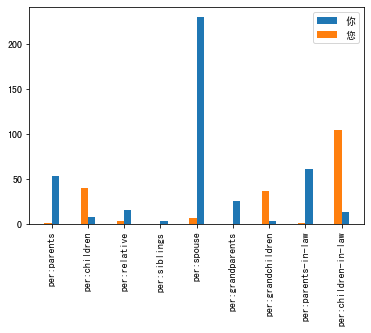

In [69]:
#graph
ni = get_scene_stats(partition1,'你')['relation']
nin = get_scene_stats(partition1,'您')['relation']

plt.rcParams['font.sans-serif'] = ['SimHei']


fig, ax = plt.subplots()

ax.bar(ni.keys(), ni.values(), width=0.2, align='edge', label='你')
ax.bar(nin.keys(), nin.values(), width=-0.2, align='edge', label='您')


ax.legend()
plt.xticks(rotation=90)


fig.show()

In [71]:
get_scene_stats(partition1,'请')

{'total_instances': 12,
 'relation': {'per:parents': 1,
  'per:spouse': 3,
  'per:children-in-law': 2,
  'per:parents-in-law': 1,
  'per:grandchildren': 2,
  'per:grandparents': 3},
 'x,y,r': {'傅,贾志新,per:parents': 1,
  '贾,和平,per:spouse': 2,
  '和,贾志国,per:spouse': 1,
  '和,傅明,per:children-in-law': 2,
  '傅,和平,per:parents-in-law': 1,
  '贾,傅明,per:grandchildren': 2,
  '傅,贾圆圆,per:grandparents': 3}}

Look at 只是， 不过, 但是, and 可是 

In [5]:
zhishi = get_scene_stats(partition1,'只是')['relation']
buguo = get_scene_stats(partition1,'不过')['relation']
danshi = get_scene_stats(partition1,'但是')['relation']
keshi = get_scene_stats(partition1,'可是')['relation']

In [43]:
zhishi

{'per:parents': 1, 'per:children': 1, 'per:spouse': 1}

In [6]:
all_keys = list(keshi.keys())+list(zhishi.keys())+list(buguo.keys())+ list(danshi.keys())

for item in all_keys:

    if item not in zhishi.keys():
        zhishi[item]=0
    if item not in buguo.keys():
        buguo[item]=0
    if item not in danshi.keys():
        danshi[item]=0
    if item not in keshi.keys():
        keshi[item]=0

In [7]:

keshi = collections.OrderedDict(sorted(keshi.items()))
danshi = collections.OrderedDict(sorted(danshi.items()))
buguo = collections.OrderedDict(sorted(buguo.items()))
zhishi = collections.OrderedDict(sorted(zhishi.items()))

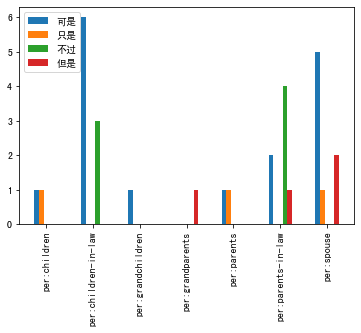

In [8]:
# set width of bar
barWidth = 0.1

X = np.arange(len(keshi))

plt.rcParams['font.sans-serif'] = ['SimHei']

fig, ax = plt.subplots()


ax.bar(X-2*barWidth, keshi.values(), width=barWidth, align='center', label='可是')
ax.bar(X-barWidth, zhishi.values(), width=barWidth, align='center', label='只是') #zhishi.keys()
ax.bar(X+barWidth, buguo.values(), width=barWidth, align='center', label='不过')
ax.bar(X+2*barWidth, danshi.values(), width=barWidth, align='center', label='但是')


ax.legend()
plt.xticks(X,keshi.keys(), rotation=90)


fig.show()

In [15]:
with open('formal_seeds_100_CN.txt','r') as infile:
    formal_vocab = list(infile.read().split('\n'))
formal_vocab = formal_vocab[0:len(formal_vocab)-1]
len(formal_vocab)

49

In [16]:
with open('informal_seeds_100_CN.txt','r') as infile:
    informal_vocab = list(infile.read().split('\n'))
informal_vocab = informal_vocab[0:len(informal_vocab)-1]
len(informal_vocab)

43

In [32]:
formal_vocab

['固然',
 '因此',
 '故而',
 '尤为',
 '偶然',
 '此后',
 '从而',
 '迄今',
 '变更',
 '无论',
 '诚挚',
 '替代',
 '争议',
 '饶恕',
 '立即',
 '缺乏',
 '无防',
 '充分',
 '相称',
 '急剧',
 '武断',
 '费解',
 '荒谬',
 '惊诧',
 '精准',
 '繁荣',
 '繁茂',
 '熟谙',
 '迅速',
 '典范',
 '粪便',
 '排泄',
 '搪塞',
 '欺诈',
 '酗酒',
 '闭塞',
 '肮脏',
 '酷毙',
 '美眉',
 '小强',
 '酱紫',
 '帅呆',
 '弓虽',
 '狂顶',
 '东东',
 '恐龙',
 '菜鸟',
 '大虾',
 '马屁']

In [40]:
formal_wc = get_scene_stats(partition1,formal_vocab)
formal_wc

{'total_instances': 4,
 'relation': {'per:parents': 1,
  'per:spouse': 1,
  'per:parents-in-law': 1,
  'per:grandparents': 1},
 'x,y,r': {'和,贾圆圆,per:parents': 1,
  '贾,和平,per:spouse': 1,
  '傅,和平,per:parents-in-law': 1,
  '傅,贾圆圆,per:grandparents': 1}}

In [41]:
informal_wc = get_scene_stats(partition1,informal_vocab)
informal_wc

{'total_instances': 119,
 'relation': {'per:spouse': 46,
  'per:parents': 13,
  'per:grandchildren': 3,
  'per:parents-in-law': 19,
  'per:children': 7,
  'per:children-in-law': 21,
  'per:relative': 4,
  'per:grandparents': 6},
 'x,y,r': {'和,贾志国,per:spouse': 28,
  '和,贾圆圆,per:parents': 9,
  '贾,和平,per:spouse': 18,
  '贾,傅明,per:grandchildren': 3,
  '傅,和平,per:parents-in-law': 19,
  '傅,贾志国,per:parents': 1,
  '贾,傅明,per:children': 3,
  '和,傅明,per:children-in-law': 21,
  '贾,贾圆圆,per:relative': 2,
  '贾,贾志国,per:children': 2,
  '贾,和平,per:children': 2,
  '傅,贾圆圆,per:grandparents': 6,
  '傅,贾志新,per:parents': 2,
  '贾,和平,per:relative': 2,
  '傅,贾小凡,per:parents': 1}}

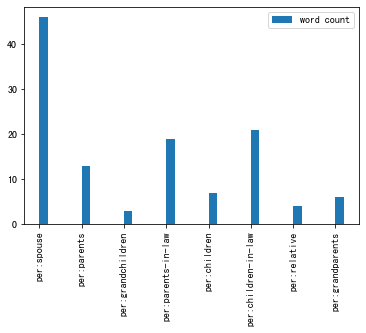

In [43]:
#graph
informal_pl = informal_wc['relation']


plt.rcParams['font.sans-serif'] = ['SimHei']


fig, ax = plt.subplots()

ax.bar(informal_pl.keys(), informal_pl.values(), width=0.2, align='edge', label='word count')


ax.legend()
plt.xticks(rotation=90)


fig.show()

In [50]:
output = dict()
output['wc']=0
output['relation'] = dict()
output['x,y,r'] = dict()

for scene in partition1:
    for line in scene:

        for word in line['tokenized']:

            output['wc']+=1

            if line['relation_item']['r'][0] not in output['relation']:
                output['relation'][line['relation_item']['r'][0]] = 0
            output['relation'][line['relation_item']['r'][0]] +=1

            x_y_r = line['relation_item']['x'][0]+','+line['relation_item']['y']+','+line['relation_item']['r'][0]

            if x_y_r not in output['x,y,r']:
                output['x,y,r'][x_y_r] = 0
            output['x,y,r'][x_y_r] +=1
            
output_pl = output['relation']
for item in output['relation'].keys():
    output['relation'][item] = 100*output['relation'][item]/output['wc']

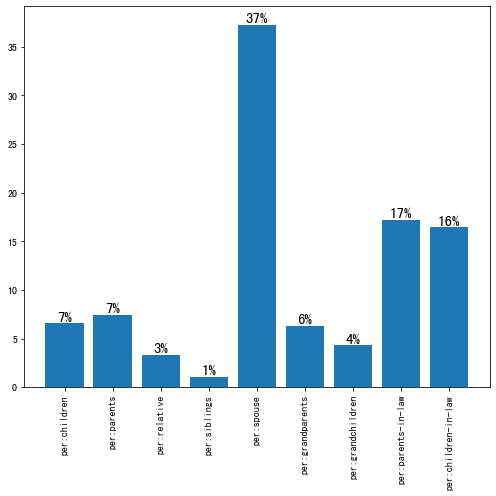

In [65]:
#graph
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True

plt.figure()

p1 = plt.bar(np.arange(len(output_pl)), output_pl.values())

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(round(height),1),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=15)

ax.legend()
plt.xticks(np.arange(len(output_pl)),output_pl.keys(),rotation=90)
plt.show()

Analysis: make a correlation matrix among the 32 relations. Surely per:parent and per:child must occur together frequently

In [2]:
with open('rid_to_rel.pickle','rb') as infile:
    rid_to_rel = pickle.load(infile)

with open('rel_to_rid.pickle','rb') as infile:
    rel_to_rid = pickle.load(infile)

In [3]:
with open('../CRECIL/Final_Data/train.json','rb') as infile:
    train_df = json.loads(infile.read())

In [7]:
#create empty data frame
zero_data = np.zeros(shape=(len(train_df),len(rid_to_rel)))
gt_df = pd.DataFrame(zero_data, columns=rid_to_rel.values())

In [8]:
for i in range(0,len(train_df)):
    for rel_item in train_df[i][1]:
        for j in rel_item['rid']:
            gt_df.iat[i,j] = 1

In [9]:
corr_matrix = gt_df.corr()

In [10]:
corr_matrix

,per:alternate_name,per:children,per:parents,per:acquaintance,per:client,per:colleague,per:ex-girlfriend,per:girlfriend,per:dates,per:ex-boyfriend,...,per:siblings,per:spouse,per:grandparents,per:grandchildren,per:teacher,per:student,per:roommate,per:relative,per:siblings-in-law,unanswerable
per:alternate_name,1.000000,0.117070,0.117070,0.055997,0.080460,0.085296,0.069229,0.078680,0.063102,0.069229,...,0.069274,0.108441,0.092696,0.092696,0.048484,0.048484,0.016026,0.095654,0.042669,0.090971
per:children,0.117070,1.000000,1.000000,-0.006048,-0.033970,-0.037705,-0.128090,-0.150463,-0.115819,-0.128090,...,0.268160,0.516230,0.402224,0.402224,-0.020470,-0.020470,0.027564,0.271393,0.034214,0.099455
per:parents,0.117070,1.000000,1.000000,-0.006048,-0.033970,-0.037705,-0.128090,-0.150463,-0.115819,-0.128090,...,0.268160,0.516230,0.402224,0.402224,-0.020470,-0.020470,0.027564,0.271393,0.034214,0.099455
per:acquaintance,0.055997,-0.006048,-0.006048,1.000000,-0.043498,-0.021592,-0.022164,-0.013124,0.058844,-0.022164,...,0.039423,0.093797,0.092402,0.092402,0.069985,0.069985,-0.019263,-0.043313,-0.051286,0.027149
per:client,0.080460,-0.033970,-0.033970,-0.043498,1.000000,0.099027,-0.045087,-0.051243,-0.058975,-0.045087,...,-0.081649,-0.087550,-0.056349,-0.056349,-0.031576,-0.031576,-0.010438,-0.102300,-0.027789,0.131067
per:colleague,0.085296,-0.037705,-0.037705,-0.021592,0.099027,1.000000,-0.048390,-0.034804,0.043607,-0.048390,...,-0.139865,-0.025027,-0.025115,-0.025115,-0.055904,-0.055904,-0.018479,-0.099105,0.249716,0.149115
per:ex-girlfriend,0.069229,-0.128090,-0.128090,-0.022164,-0.045087,-0.048390,1.000000,0.777210,0.538054,1.000000,...,-0.005680,-0.064143,-0.031815,-0.031815,0.134502,0.134502,-0.008981,0.045175,-0.023910,0.112771
per:girlfriend,0.078680,-0.150463,-0.150463,-0.013124,-0.051243,-0.034804,0.777210,1.000000,0.506325,0.777210,...,-0.054955,-0.097220,-0.069105,-0.069105,0.041021,0.041021,-0.010207,0.005557,-0.027174,0.128167
per:dates,0.063102,-0.115819,-0.115819,0.058844,-0.058975,0.043607,0.538054,0.506325,1.000000,0.538054,...,-0.020943,-0.107310,-0.059057,-0.059057,0.027903,0.027903,-0.011747,0.053030,-0.031275,0.087760
per:ex-boyfriend,0.069229,-0.128090,-0.128090,-0.022164,-0.045087,-0.048390,1.000000,0.777210,0.538054,1.000000,...,-0.005680,-0.064143,-0.031815,-0.031815,0.134502,0.134502,-0.008981,0.045175,-0.023910,0.112771


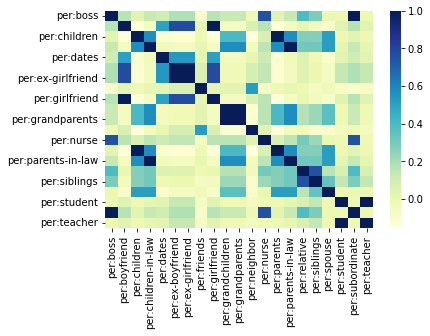

In [13]:
#code for heatmap from https://datascience.stackexchange.com/questions/82226/how-to-visualise-a-large-correlation-matrix
from numpy.random      import randn
from pandas            import DataFrame
from seaborn           import heatmap
from matplotlib.pyplot import show
from itertools         import combinations

def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

labels = [chr(x) for x in range(65,91)]

heatmap(absHighPass(corr_matrix,0.5),cmap="YlGnBu")
show()

In [18]:

for (r,c) in combinations(corr_matrix.columns, 2):
    if (abs(corr_matrix.loc[r,c]) >= 0.9):
        print((r,c))
        print(corr_matrix.loc[r,c])

        

('per:children', 'per:parents')
1.0
('per:ex-girlfriend', 'per:ex-boyfriend')
1.0
('per:girlfriend', 'per:boyfriend')
1.0
('per:parents-in-law', 'per:children-in-law')
1.0
('per:subordinate', 'per:boss')
1.0
('per:grandparents', 'per:grandchildren')
1.0
('per:teacher', 'per:student')
1.0


In [19]:
for (r,c) in combinations(corr_matrix.columns, 2):
    if (abs(corr_matrix.loc[r,c]) >= 0.7) and (abs(corr_matrix.loc[r,c]) !=1.0):
        print((r,c))
        print(corr_matrix.loc[r,c])

('per:ex-girlfriend', 'per:girlfriend')
0.7772099563215646
('per:ex-girlfriend', 'per:boyfriend')
0.7772099563215646
('per:girlfriend', 'per:ex-boyfriend')
0.7772099563215646
('per:ex-boyfriend', 'per:boyfriend')
0.7772099563215646
('per:nurse', 'per:subordinate')
0.7588329056007194
('per:nurse', 'per:boss')
0.7588329056007194
('per:siblings', 'per:relative')
0.757021837812396


In [6]:
def get_num_speakers(transcript:list)-> int:
    """
    return number of speakers in scene
    """
    ch_set = set()
    for line in transcript:
        ch_set.add(re.findall('S.*(?=:)',line)[0])
    
    total = len(ch_set)
    return total

In [7]:
dialog_size_d = dict()
for rel in list(rel_to_rid.keys()):
    dialog_size_d[rel] = []

for i in range(0,len(train_df)):
    
    d_size = get_num_speakers(train_df[i][0])
    
    for item in train_df[i][1]:
        for rel in item['r']:
            dialog_size_d[rel].append(d_size)

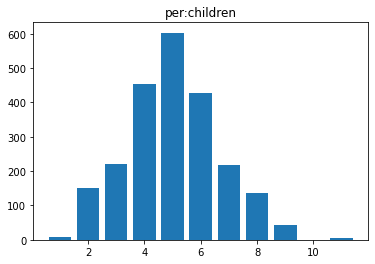

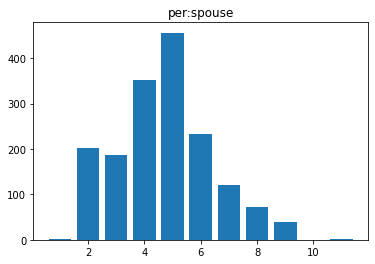

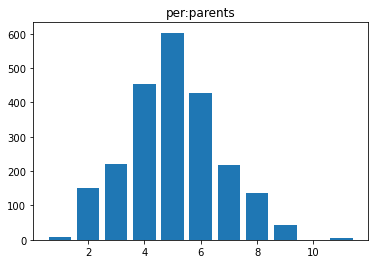

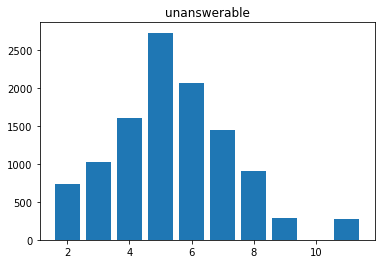

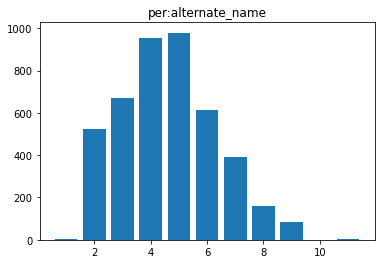

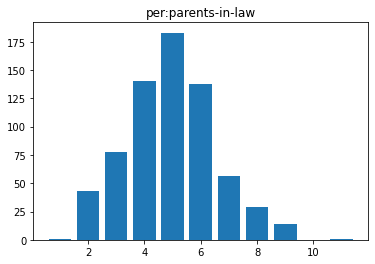

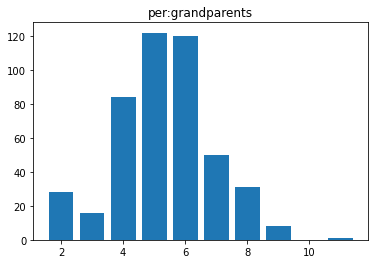

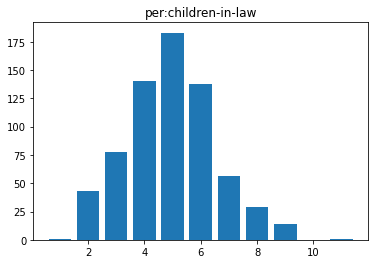

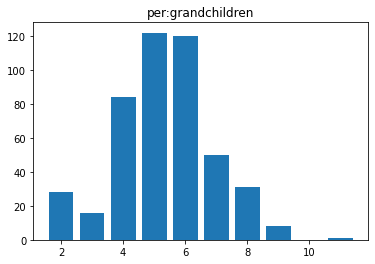

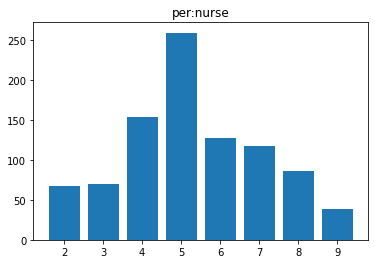

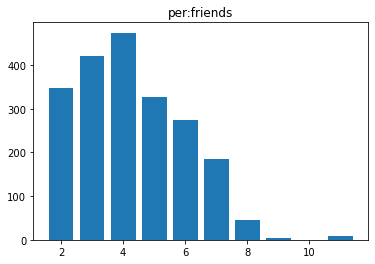

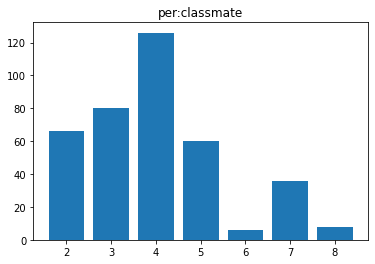

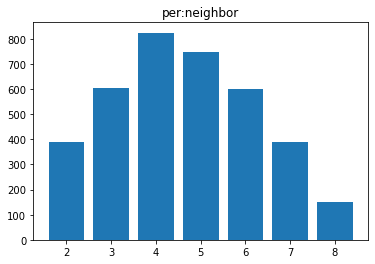

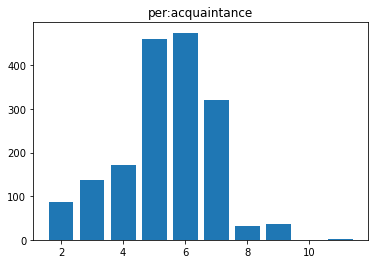

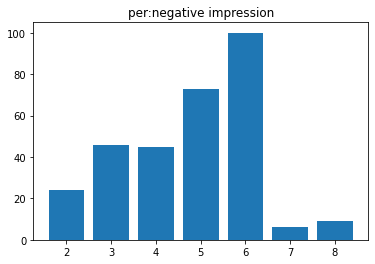

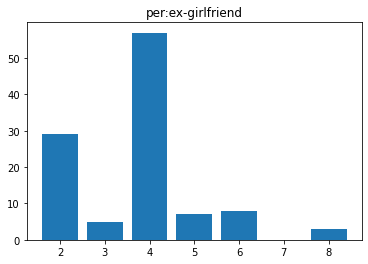

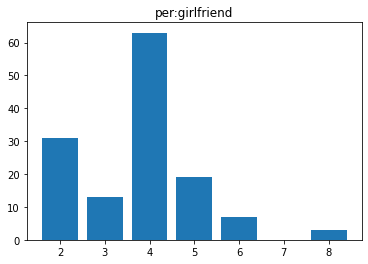

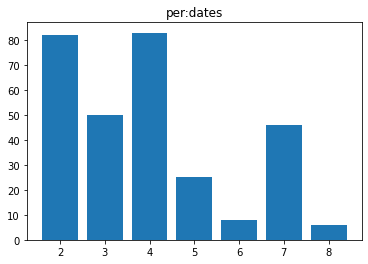

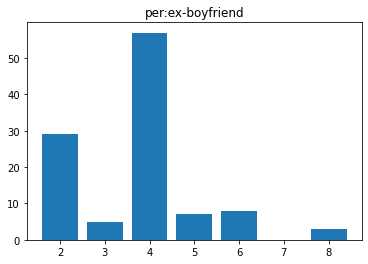

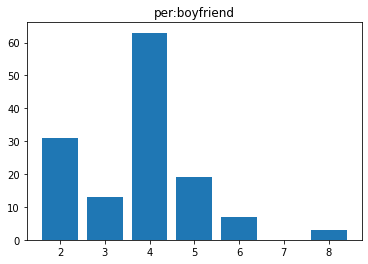

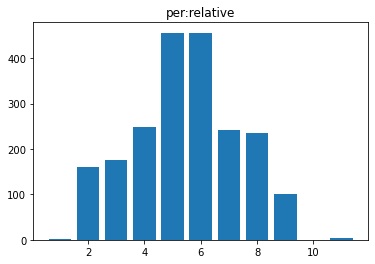

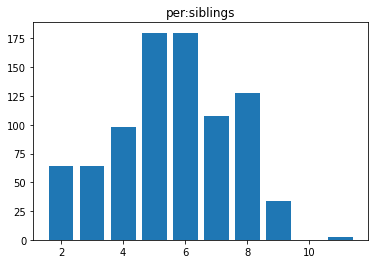

In [ ]:


#iterate for each stock
for pair in rel_to_rid.keys():
    
    c = collections.Counter(dialog_size_d[pair])
    c = sorted(c.items())

    plt.bar([item[0] for item in c],[item[1] for item in c])
    plt.title(pair)
    plt.show()


In [5]:
len(partition1) #75 lines

75

In [6]:
total = 0 #1346 lines
for scene in partition1:
    total+=len(scene)
total

1346

In [18]:
partition1[0]

[{'original_line': '贾志新: 爸，您这就上中央开会去啦？',
  'speaker': '贾志新',
  'relation_item': {'x': '贾志新', 'y': '傅明', 'r': ['per:children'], 'rid': [1]},
  'line_clean': '爸，您这就上中央开会去啦？',
  'tokenized': ['爸', '，', '您', '这', '就', '上', '中央', '开会', '去', '啦', '？', '']},
 {'original_line': '傅明: 上街道。',
  'speaker': '傅明',
  'relation_item': {'x': '傅明', 'y': '贾志新', 'r': ['per:parents'], 'rid': [2]},
  'line_clean': '上街道。',
  'tokenized': ['上', '街道', '。', '']},
 {'original_line': '贾志新: 哦。看您打扮得这样儿，我寻思您直接就奔政治局啦——知道门朝哪边儿开吗？',
  'speaker': '贾志新',
  'relation_item': {'x': '贾志新', 'y': '傅明', 'r': ['per:children'], 'rid': [1]},
  'line_clean': '哦。看您打扮得这样儿，我寻思您直接就奔政治局啦——知道门朝哪边儿开吗？',
  'tokenized': ['哦',
   '。',
   '看',
   '您',
   '打扮',
   '得',
   '这样儿',
   '，',
   '我',
   '寻思',
   '您',
   '直接',
   '就',
   '奔',
   '政治局',
   '啦',
   '—',
   '—',
   '知道',
   '门',
   '朝',
   '哪',
   '边儿',
   '开',
   '吗',
   '？',
   '']},
 {'original_line': '傅明: 坐北朝南……你少讽刺我！今天是街道上有个老有所为座谈会，小余非让我去听一听。我忙啊，本来也没时间去，后来一考虑……',
  'speaker': '傅明',

In [67]:
#add 'addressee' to dict for each scene
for scene in partition1:

    #get 2 relations:
    relations = set()
    for item in scene:
        relations.add(item['relation_item']['r'][0])

    for item in scene:

        addressee = relations.difference({item['relation_item']['r'][0]})
        if len(addressee)==1:
            item['addressee'] = addressee
        elif len(addressee)==0: #relations are identical
            
            item['addressee'] = relations

**Two bar-graph or table questions**: <br/>
1. How many lines are spoken for each relation pair?
2. For each indentifiable speaker, how many difference relation scenes are they a part of?

In [73]:
#1.
pairing_count = dict()
pattern = re.compile('(?<=:).*')

for scene in partition1:
    #get 2 relations:
    
    s1 = scene[0]['relation_item']['r'][0]
    s2 = list(scene[0]['addressee'])[0]
    a_list = [s1,s2]
    a_list= sorted(a_list)
    
    category = re.findall(pattern,a_list[0])[0]+'_'+re.findall(pattern,a_list[1])[0]
    if category not in pairing_count:
        pairing_count[category] = 0
    pairing_count[category] +=1

In [74]:
pairing_count

{'children_parents': 18,
 'relative_relative': 5,
 'siblings_siblings': 1,
 'spouse_spouse': 21,
 'grandchildren_grandparents': 9,
 'children-in-law_parents-in-law': 21}

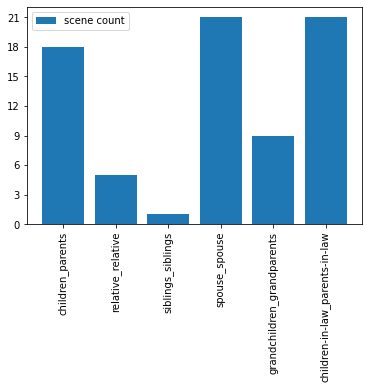

In [77]:
#graph
from matplotlib.ticker import MaxNLocator


fig, ax = plt.subplots()

ax.bar(pairing_count.keys(), pairing_count.values(),  label='scene count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend()
plt.xticks(rotation=90)


fig.show()

In [78]:
partition1[0][0]

{'original_line': '贾志新: 爸，您这就上中央开会去啦？',
 'speaker': '贾志新',
 'relation_item': {'x': '贾志新', 'y': '傅明', 'r': ['per:children'], 'rid': [1]},
 'line_clean': '爸，您这就上中央开会去啦？',
 'tokenized': ['爸', '，', '您', '这', '就', '上', '中央', '开会', '去', '啦', '？', ''],
 'addressee': {'per:parents'}}

In [87]:
characters = dict()
pattern = re.compile('(?<=:).*')

for scene in partition1:
    
    for item in scene:
        
        s1 = item['relation_item']['r'][0]
        s2 = list(item['addressee'])[0]

        re.findall(pattern,s1)[0]+'_'+re.findall(pattern,s2)[0]
        category = s1+'_'+s2      

        if item['speaker'] not in characters:
            characters[item['speaker']] = dict()

        if category not in characters[item['speaker']]:
            characters[item['speaker']][category] = 0
        characters[item['speaker']][category] +=1

In [88]:
characters

{'贾志新': {'per:children_per:parents': 22,
  'per:siblings_per:siblings': 6,
  'per:relative_per:relative': 9},
 '傅明': {'per:parents_per:children': 64,
  'per:grandparents_per:grandchildren': 77,
  'per:parents-in-law_per:children-in-law': 229},
 '贾圆圆': {'per:relative_per:relative': 13,
  'per:grandchildren_per:grandparents': 73,
  'per:children_per:parents': 50},
 '贾小凡': {'per:relative_per:relative': 10,
  'per:siblings_per:siblings': 4,
  'per:children_per:parents': 5},
 '和平': {'per:relative_per:relative': 4,
  'per:spouse_per:spouse': 228,
  'per:children-in-law_per:parents-in-law': 235,
  'per:parents_per:children': 44},
 '贾志国': {'per:spouse_per:spouse': 226,
  'per:children_per:parents': 38,
  'per:parents_per:children': 9}}